Groundwater | Case Study
# Template Student Task: Groundwater Well Group Impact Assessment
Dr. Xiang-Zhao Kong & Dr. Beatrice Marti & Louise Noël du Payrat

## 1 Overview and Learning Objectives

In this case study, you are tasked with **evaluating the impact of a well group on the regional groundwater flow field** through a comprehensive three-stage modeling approach:

1. **Base model (no wells)**: Regional groundwater conditions without your assigned well group operating
2. **Base model with wells**: Current groundwater extraction/injection rates at your assigned well group implemented in the telescope submodel
3. **Scenario conditions**: Modified forcing conditions (e.g., changed recharge, boundary conditions, or pumping rates) implemented in the regional model, with impacts assessed through the telescope submodel

This notebook demonstrates the complete **telescope modeling workflow** (also called sub-modeling or child modeling approach) that you will use to complete your assessment. The telescope approach involves:

- Creating a **high-resolution submodel** in the area of interest around your well group
- Extracting **boundary conditions** from the regional parent model to properly nest the submodel
- Running three sequential simulations to assess cumulative and scenario-specific impacts
- Comparing results to quantify changes in groundwater flow patterns, drawdowns, and capture zones


### 1.1 Why Use the Telescope Approach?

The telescope approach is essential because:
- **Computational efficiency**: We can achieve fine-scale resolution (5m cells) around wells without requiring the entire regional model to be refined
- **Proper boundary conditions**: The submodel receives realistic boundary conditions from the regional model simulation
- **Scale-appropriate analysis**: Local well impacts require high resolution that regional models cannot provide efficiently
- **Industry standard**: This nested modeling approach is widely used in professional groundwater consulting
- **Scenario flexibility**: Changes to regional forcings can be easily propagated to the local scale

### 1.2 Three-Stage Modeling Workflow

**Stage 1: Base Regional Model (No Wells)**
- Run regional model without well group to establish baseline conditions
- Extract boundary conditions for telescope submodel
- Document natural groundwater flow patterns in the submodel

**Stage 2: Base Model with Wells**  
- Implement well group in telescope submodel using Stage 1 boundary conditions
- Assess direct impact of well operations on local flow field
- Quantify drawdowns and capture zones under current conditions

**Stage 3: Scenario Assessment**
- Modify forcing conditions in regional model (e.g., changed recharge, boundary conditions)
- Re-extract boundary conditions from updated regional model
- Run telescope submodel with new boundary conditions to assess combined impacts
- Compare Stage 3 vs Stage 2 in the submodel to isolate scenario-specific effects

### 1.3 Your Task

1. **Copy and adapt this notebook** for your specific well group configuration
2. **Modify the parameters** in the case_config.yaml and in your copy of this notebook (group number, buffer distances, pumping rates) as needed for your assignment
3. **Execute the three-stage workflow** systematically
4. **Analyze and compare results** between all three stages to understand:
   - Direct well impacts (Stage 2 vs Stage 1)
   - Scenario impacts (Stage 3 vs Stage 2)  
   - Combined effects (Stage 3 vs Stage 1)
5. **Document your findings** for inclusion in your final report and presentation

The results from your three-stage submodel analysis will form a key component of your **final report and presentation**, demonstrating your understanding of groundwater flow processes, numerical modeling techniques, and scenario assessment at multiple scales.

3. **Execute the three-stage workflow** systematically
4. **Analyze and compare results** between all three stages to understand:
   - Direct well impacts (Stage 2 vs Stage 1)
   - Scenario impacts (Stage 3 vs Stage 2)  
   - Combined effects (Stage 3 vs Stage 1)
5. **Document your findings** for inclusion in your final report and presentation

### 1.4 Essential Checklist - Search for #TODO in Your Code

Before running your analysis, **search for "#TODO" in your notebook copy** to find all locations requiring your attention. Key items to verify:

**Model Configuration:**
- [ ] **Group number** matches your assignment in case_config.yaml
- [ ] **Well pumping rates** reflect actual concessioned rates from maps.zh.ch
- [ ] **Buffer distances** are adequate for your well field (check 10+ day travel times)
- [ ] **Cell size** provides sufficient resolution around wells (typically 5m or finer)

**Boundary Conditions:**
- [ ] **Submodel extent** captures full zone of influence from your wells
- [ ] **Parent model results** available for all three stages (base, with wells, scenario)
- [ ] **Boundary extraction** properly maps heads from parent to submodel grid

**Well Implementation:**
- [ ] **Well locations** correctly mapped to active (non-CHD) cells
- [ ] **Pumping/injection rates** assigned according to well type (FASSART)
- [ ] **Well depths** and completion intervals realistic for local hydrogeology

**Quality Control:**
- [ ] **Mass balance** acceptable (<1% error) for all model runs  
- [ ] **Head distributions** physically reasonable (no extreme gradients)
- [ ] **Flow patterns** consistent with regional hydrogeology
- [ ] **Convergence** achieved within iteration limits

**Analysis Requirements:**
- [ ] **Three-stage comparison** completed with clear quantification of impacts
- [ ] **Results documentation** prepared for final report and presentation
- [ ] **Sensitivity analysis** of key parameters (optional but recommended)

The results from your three-stage submodel analysis will form a key component of your **final report and presentation**, demonstrating your understanding of groundwater flow processes, numerical modeling techniques, and scenario assessment at multiple scales.

**⚠️ Important:** If your initial results show well impacts extending to the submodel boundaries, **increase your buffer distances and re-run the analysis**. The submodel domain must be large enough to contain the full zone of influence.

### 1.4 Expected Deliverables

Your analysis should quantify:
- Changes in hydraulic head distribution around the well field
- Modifications to groundwater flow directions and magnitudes  
- Impacts on capture zones and areas of influence
- Mass balance considerations and boundary interactions
- Assessment of potential impacts on neighboring wells or environmental features

Let's begin by implementing the telescope modeling workflow for your assigned well group.

## 2 Create the Telescope Submodel sub_base

This notebook demonstrates how to create a refined submodel around wells using the same boundary polygon approach and grid generation workflow established in notebook 4. Instead of working directly with grid indices, we'll create a proper boundary polygon for the submodel domain and then apply the proven workflow.

### 2.1 Approach Overview

1. **Load base model and identify wells** from case study configuration
2. **Define buffer distances** around wells based on hydrogeological considerations  
3. **Create submodel boundary polygon** using buffer distances
4. **Generate refined grid** using the same workflow from notebook 4
5. **Extract boundary conditions** from parent model results
6. **Extract and interpolate aquifer properties** to the refined grid ()
7. **Set up and run** the complete submodel

This approach ensures consistency with the established grid generation methodology while providing the fine-scale resolution needed around wells.

### 2.2 Set Up Your Working Environment 
#### 2.2.1 Configure your Group Information
Your first task is to configure your group information in the case_config.yaml file located in your group's working folder. This file contains essential metadata about your group and will be used throughout the case study.

`#TODO`: Update your group number in case_config.yaml in your groups working folder

> **Example:** CASE_STUDY/student_work/group_0/case_config.yaml
> 
> Below, you see example content of case_config.yaml. Look for #TODO in the yaml file and update the group number and authors accordingly. 
>
> ```yaml
> group:   
>   number: 0               # TODO: integer group number (0-8).  
>   authors:                # TODO: list all group members (2–3 persons).  
>     - "Hedwig Muster"   
>     - "Karl Beispiel"     # add third if needed    
> ```

In [1]:
# Import required libraries
import sys
import os
import numpy as np
import pickle
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from shapely.geometry import Point, Polygon
from shapely.affinity import rotate
import flopy
from flopy.discretization import StructuredGrid

# print current working directory
print("Current working directory: ", os.getcwd())

# Add the support repo to the path
sys.path.append(os.path.abspath('../../../SUPPORT_REPO/src'))
sys.path.append(os.path.abspath('../../../SUPPORT_REPO/src/scripts/scripts_exercises'))

# Import local modules
import case_utils 
from data_utils import download_named_file, get_default_data_folder
import grid_utils
from print_images import display_image
import plot_utils

Current working directory:  /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY/student_work/group_0
Starting search for project root from: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY/student_work/group_0
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY/student_work/group_0
Marker file not found in /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY/student_work/group_0. Moving up...
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY/student_work
Marker file not found in /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY/student_work. Moving up...
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
Marker file not found in /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY. Moving up...
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling
Found project root: /Users/bea/Docum

#### 2.2.2 Load Base Model 

We'll load the parent MODFLOW model and identify well locations from the case study configuration. This follows the same approach as the case study template but focuses on creating a proper submodel domain.

In [2]:
# Load case study configuration
CASE_YAML = 'case_config.yaml'
cfg = case_utils.load_yaml(CASE_YAML)

# Get group configuration
group_number = cfg['group'].get('number', 0)
if not isinstance(group_number, int) or group_number < 0 or group_number > 8:
    raise ValueError("Group number must be an integer between 0 and 8.")

print(f"Group number: {group_number}")

# Download parent base model and save it to your workspace
parent_base_model_name = cfg['model']['data_name']
parent_base_model_path = download_named_file(
    parent_base_model_name, 
    data_type='baseline_model',
)

# Handle zip file extraction if needed
if parent_base_model_path.endswith('.zip'):
    import zipfile
    extract_path = os.path.dirname(parent_base_model_path)
    with zipfile.ZipFile(parent_base_model_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    parent_base_model_path = os.path.join(extract_path, parent_base_model_name + '.nam')

print(f'Downloaded the parent base model to path: {parent_base_model_path}')

Group number: 0
limmat_valley_base_model_nwt.zip already exists in /Users/bea/applied_groundwater_modelling_data/limmat/baseline_model.
limmat_valley_base_model_nwt_readme.md already exists in /Users/bea/applied_groundwater_modelling_data/limmat/baseline_model.
Downloaded the parent base model to path: /Users/bea/applied_groundwater_modelling_data/limmat/baseline_model/baseline_model.nam


#### 2.2.3 Define names & paths for scenarios and base model
We will define the names and paths for the base model and scenarios based on your group configuration.

We will have multiple models we are running in this case study: 
- Parent base model (as developed in notebook 4): Identified with prefix `parent_base`  
- Submodel with boundary conditions from parent base model: Identified with prefix `submodel_base`
- Submodel with boundary conditions from parent base model and wells implemented: Identified with prefix `submodel_wells`
- Parent model with scenario conditions (e.g., changed recharge, boundary conditions): Identified with prefix `parent_scenario`
- Submodel with boundary conditions from parent scenario model and wells implemented: Identified with prefix `submodel_scenario`

In [3]:
# For each model, we will create a dedicated output workspace
parent_base_ws = os.path.expanduser(cfg['output']['workspace'])
# Add group number to path and add sub-directory for the parent base model
parent_base_ws = parent_base_ws + str(group_number) + "/parent_base"
case_utils.ensure_dir(parent_base_ws)
# Set up workspace for parent scenario model
parent_scenario_ws = parent_base_ws.replace('parent_base', 'parent_scenario')
case_utils.ensure_dir(parent_scenario_ws)

# Set up workspace for submodels
sub_base_ws = parent_base_ws.replace('parent_base', 'sub_base')
case_utils.ensure_dir(sub_base_ws)
sub_wells_ws = parent_base_ws.replace('parent_base', 'sub_wells')
case_utils.ensure_dir(sub_wells_ws)
sub_scenario_ws = parent_base_ws.replace('parent_base', 'sub_scenario')
case_utils.ensure_dir(sub_scenario_ws)

# Set up a folder to store comparison plots and analysis
results_ws = parent_base_ws.replace('parent_base', 'results')
case_utils.ensure_dir(results_ws)

# Set up a folder to store grid files and shapefiles
grids_ws = parent_base_ws.replace('parent_base', 'grids')
case_utils.ensure_dir(grids_ws)


#### 2.2.4 Inspect the Parent Base Model and save to your workspace
In this section, we load the groundwater flow model we have developed in notebook 4. This is the parent base model without wells. We will inspect the model and save a copy to your workspace for further processing.

##### Load & Copy Parent Base Model

In [4]:
# Load the baseline model
namefile = cfg['model']['namefile']  # Name of your model files, does not change
print(f'Loading parent base model from namefile: {namefile}')
print(f'From folder: {os.path.dirname(parent_base_model_path)}')
m_parent_base = flopy.modflow.Modflow.load(
    namefile, 
    model_ws=os.path.dirname(parent_base_model_path),
    forgive=True, 
    check=False, 
    exe_name='mfnwt'
)
# Change workspace to the new directory parent_base_ws
m_parent_base.model_ws = parent_base_ws
# Write all input files to the new location
m_parent_base.write_input()

print(f'Loaded parent base model: {m_parent_base.name}')
print(f'Input files written to: {parent_base_ws}')

Loading parent base model from namefile: limmat_valley_model_nwt.nam
From folder: /Users/bea/applied_groundwater_modelling_data/limmat/baseline_model
Loaded parent base model: limmat_valley_model_nwt
Input files written to: /Users/bea/applied_groundwater_modelling_data/limmat/case_study_group_0/parent_base


##### Steady-State Groundwater Heads of Base Model
In this section, we visualize the steady-state groundwater heads from the parent base model. This allows us to check if the model output is ready for further analysis. It further provides a reference for understanding the natural groundwater flow conditions before implementing wells.

Heads loaded from /Users/bea/applied_groundwater_modelling_data/limmat/case_study_group_0/parent_base/limmat_valley_model_nwt.hds


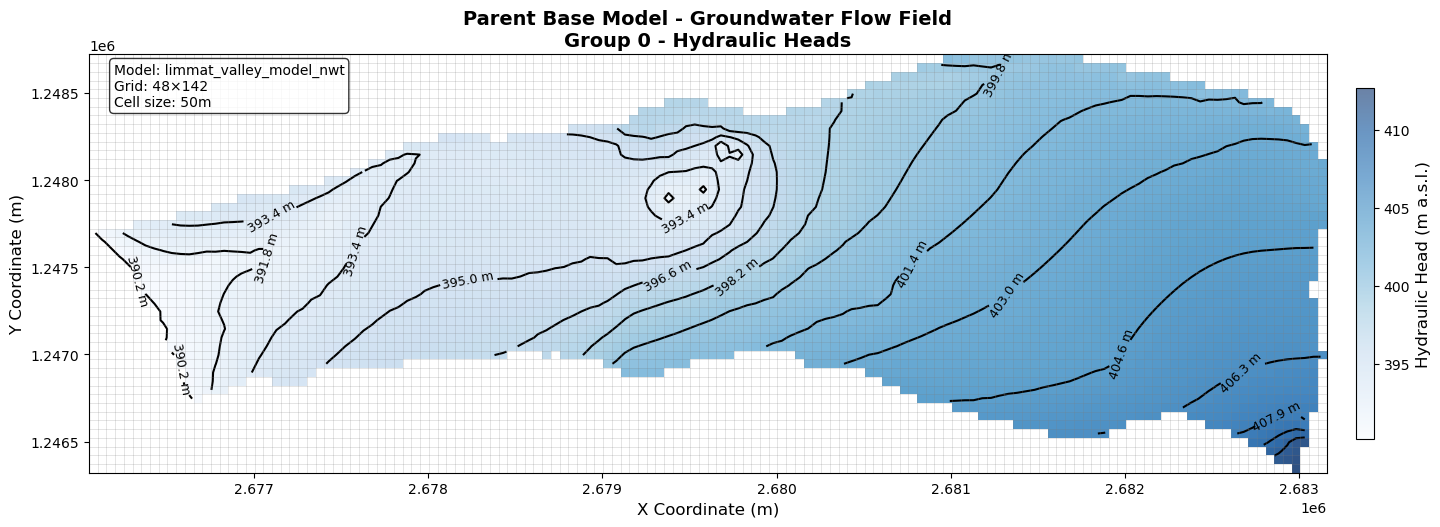

In [5]:
# ----- Load model results ----- #
# Check if heads file exists, if not run the model
parent_hds_path = os.path.join(parent_base_ws, f"{m_parent_base.name}.hds")
if not os.path.exists(parent_hds_path):
    print("Parent model heads file not found. Running parent model...")
    success, buff = m_parent_base.run_model(silent=True, report=True)
    if not success:
        raise RuntimeError("Parent model failed to run")
    print("✓ Parent model run completed")

# Load and visualize groundwater heads
headobj = flopy.utils.HeadFile(parent_hds_path)
print(f'Heads loaded from {parent_hds_path}')
heads = headobj.get_data()[0]  # Layer 0, stress period 0


# ----- Create visualization ----- #
# Create visualization
fig, ax = plt.subplots(figsize=(16, 12))

# Plot model with heads
pmv = flopy.plot.PlotMapView(model=m_parent_base, ax=ax)

# Plot head distribution as colored background
heads_masked = np.ma.masked_where(m_parent_base.bas6.ibound.array[0] <= 0, heads)
im = pmv.plot_array(heads_masked, alpha=0.6, cmap='Blues')

# Add head contours
contour_levels = np.linspace(np.nanmin(heads_masked), np.nanmax(heads_masked), 15)
cont = pmv.contour_array(heads_masked, levels=contour_levels, colors='black', 
                        linewidths=1.5, linestyles='-')
ax.clabel(cont, inline=True, fontsize=9, fmt='%.1f m')

# Plot model grid (light)
pmv.plot_grid(color='gray', alpha=0.3, linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.3, pad=0.02)
cbar.set_label('Hydraulic Head (m a.s.l.)', fontsize=12)

# Formatting
ax.set_title(f'Parent Base Model - Groundwater Flow Field\nGroup {group_number} - Hydraulic Heads', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('X Coordinate (m)', fontsize=12)
ax.set_ylabel('Y Coordinate (m)', fontsize=12)
ax.set_aspect('equal')

# Add text box with model info
info_text = f'Model: {m_parent_base.name}\nGrid: {m_parent_base.nrow}×{m_parent_base.ncol}\nCell size: {m_parent_base.dis.delr[0]:.0f}m'
ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### 2.3 Identify Well Locations and Define Buffer Distances

Constructiong modelgrid_path:
Parent model grid loaded
Grid rotation: -30 degrees
Grid extent: X [2676055.6, 2683404.4]
             Y [1246653.9, 1252282.4]
Wasserfassungen_-OGD.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Wasserfassungen_-OGD_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.

Wells for concession 210:
         GWR_ID GWR_PREFIX                                         FASSART
46   b010210_01        210  Vertikalbrunnen mit Rückversickerung: Entnahme
579  b010210_02        210  Vertikalbrunnen mit Rückversickerung: Rückgabe


(<Figure size 1400x1200 with 1 Axes>,
 <Axes: title={'center': 'Concession 210 Wells on MODFLOW Grid\nModel: limmat_valley_model_nwt | Grid: 48×142 cells'}, xlabel='X coordinate (m)', ylabel='Y coordinate (m)'>)

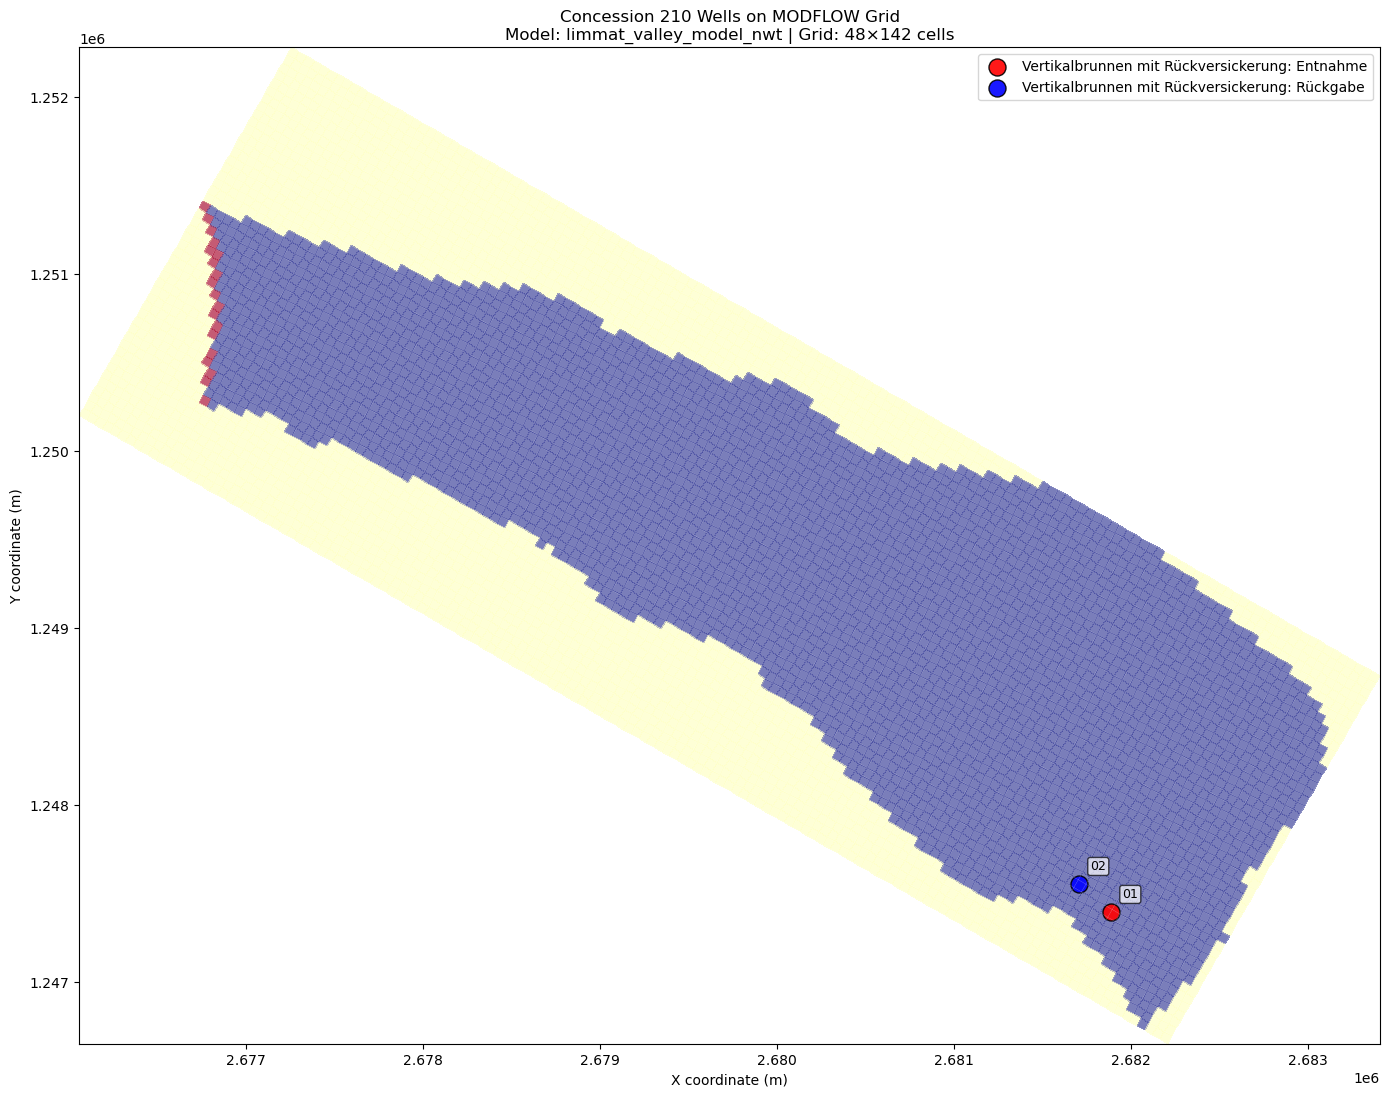

In [6]:
# Load the rotated model grid for visualization
print(f"Constructiong modelgrid_path:")
modelgrid_path = os.path.join(os.path.dirname(parent_base_model_path), f"{namefile.replace('.nam', '')}_modelgrid.pkl")
with open(modelgrid_path, 'rb') as f:
    parent_modelgrid = pickle.load(f)

print(f"Parent model grid loaded")
print(f"Grid rotation: {parent_modelgrid.angrot} degrees")
print(f"Grid extent: X [{parent_modelgrid.extent[0]:.1f}, {parent_modelgrid.extent[1]:.1f}]")
print(f"             Y [{parent_modelgrid.extent[2]:.1f}, {parent_modelgrid.extent[3]:.1f}]")

# Get well locations for the specified group
scenario = case_utils.get_scenario_for_group(CASE_YAML, group_number)
concession_id = scenario.get('concession', None)
if concession_id is None:
    raise ValueError(f"Concession ID not defined for group {group_number}")

# Load and filter wells by concession
well_data_path = download_named_file(name='wells', data_type='gis')
wells_gdf = gpd.read_file(well_data_path, layer='GS_GRUNDWASSERFASSUNGEN_OGD_P')
wells_gdf = case_utils.filter_wells_by_concession(wells_gdf, concession_id)

print(f"\nWells for concession {concession_id}:")
print(wells_gdf[['GWR_ID', 'GWR_PREFIX', 'FASSART']])

# Visualize wells on parent model
case_utils.plot_wells_on_model(m_parent_base, modelgrid=parent_modelgrid, wells_gdf=wells_gdf, 
                               concession_id=concession_id)

[maps.zh.ch](maps.zh.ch) shows the concessioned pumping rates for our well group 210 (zoom into the area where your groups wells are located and look for your groops concession number). For the demo case, we look for b1-210 where b1 is the indicator for the Limmat valley aquifer and 210 is the concession number. Click on that number to see the concessioned pumping rates in the Info sidepane (Look for "Konzessionierte Entnahmemenge [l/min]"). In our case, the concessioned pumping rate is 1400 l/s. 

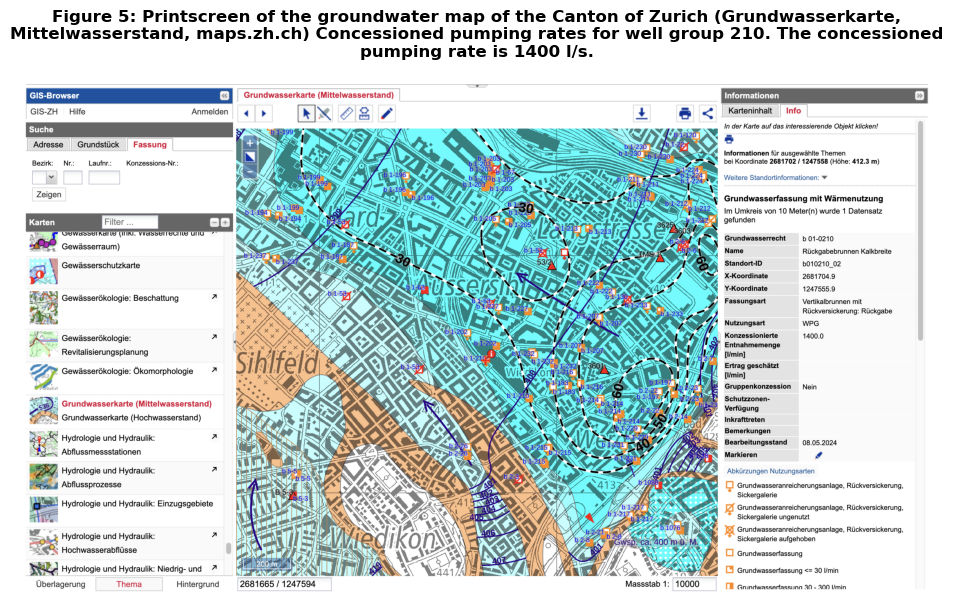

In [7]:
display_image(
    image_filename='case_study_0_concessioned_pumping_rates.png', 
    image_folder='0_case_study_demo',
    caption='Figure 5: Printscreen of the groundwater map of the Canton of Zurich (Grundwasserkarte, Mittelwasserstand, maps.zh.ch) Concessioned pumping rates for well group 210. The concessioned pumping rate is 1400 l/s.'
)

We can therefore define the pumping and infiltration rates to be 1400 l/s for our well group 210.

In [63]:
well_rates_m3d = 1400 / 1000 * 86400  # 1400 l/s converted to m3/day
round(well_rates_m3d)

120960

`#TODO`: Update the pumping rates according to your well group concessioned rates from maps.zh.ch

### 2.4 Submodel Grid Definition
Now, we define the submodel grid around our well group using the boundary polygon approach. This follows the same workflow as in notebook 4 but focuses on creating a proper submodel domain.

#### 2.4.1 Define Submodel Extent with Buffer Distances
We'll define buffer distances around the wells based on hydrogeological considerations. For the Limmat Valley, we need to account for the main flow direction and ensure adequate boundary distances for the submodel.

In [9]:
# Define submodel parameters
sub_cell_size = 5  # meters - refined resolution
parent_cell_size = parent_modelgrid.delr[0]  # parent model cell size

print(f"Parent model cell size: {parent_cell_size} m")
print(f"Submodel cell size: {sub_cell_size} m") 
print(f"Refinement ratio: {parent_cell_size/sub_cell_size}×")

# Define buffer distances in meters based on hydrogeological considerations
# These distances should provide adequate boundary conditions for the submodel
downstream_buffer_m = 400   # 400 m buffer downstream (main flow direction)
upstream_buffer_m = 400     # 400 m buffer upstream
north_buffer_m = 200        # 200 m buffer to the north
south_buffer_m = 200        # 200 m buffer to the south

print(f"\nBuffer distances:")
print(f"  Downstream: {downstream_buffer_m} m")
print(f"  Upstream: {upstream_buffer_m} m")
print(f"  North: {north_buffer_m} m")
print(f"  South: {south_buffer_m} m")

# Get well extent
well_x_min = wells_gdf.geometry.x.min()
well_x_max = wells_gdf.geometry.x.max()
well_y_min = wells_gdf.geometry.y.min()
well_y_max = wells_gdf.geometry.y.max()

print(f"\nWell extent:")
print(f"  X: [{well_x_min:.1f}, {well_x_max:.1f}] (span: {well_x_max - well_x_min:.1f} m)")
print(f"  Y: [{well_y_min:.1f}, {well_y_max:.1f}] (span: {well_y_max - well_y_min:.1f} m)")

# Calculate submodel bounds with buffers
# For Limmat Valley, assuming downstream is towards the west (negative X)
submodel_xmin = well_x_min - downstream_buffer_m
submodel_xmax = well_x_max + upstream_buffer_m  
submodel_ymin = well_y_min - south_buffer_m
submodel_ymax = well_y_max + north_buffer_m

print(f"\nSubmodel extent with buffers:")
print(f"  X: [{submodel_xmin:.1f}, {submodel_xmax:.1f}] (span: {submodel_xmax - submodel_xmin:.1f} m)")
print(f"  Y: [{submodel_ymin:.1f}, {submodel_ymax:.1f}] (span: {submodel_ymax - submodel_ymin:.1f} m)")

# Calculate expected grid dimensions
expected_ncol = int(np.ceil((submodel_xmax - submodel_xmin) / sub_cell_size))
expected_nrow = int(np.ceil((submodel_ymax - submodel_ymin) / sub_cell_size))

print(f"\nExpected submodel grid dimensions:")
print(f"  {expected_nrow} rows × {expected_ncol} cols")
print(f"  Total cells: {expected_nrow * expected_ncol:,}")

Parent model cell size: 50.0 m
Submodel cell size: 5 m
Refinement ratio: 10.0×

Buffer distances:
  Downstream: 400 m
  Upstream: 400 m
  North: 200 m
  South: 200 m

Well extent:
  X: [2681704.9, 2681885.9] (span: 181.0 m)
  Y: [1247397.8, 1247555.8] (span: 158.0 m)

Submodel extent with buffers:
  X: [2681304.9, 2682285.9] (span: 981.0 m)
  Y: [1247197.8, 1247755.8] (span: 558.0 m)

Expected submodel grid dimensions:
  112 rows × 197 cols
  Total cells: 22,064


#### 2.4.2 Create Submodel Boundary Polygon

Now we'll create a boundary polygon for the submodel domain. 

Parent model grid parameters:
  Origin (xll, yll): (2676055.6, 1250203.9)
  Rotation angle: -30 degrees
Well b010210_01: (2681885.9, 1247397.8) -> local (6452.2, 485.0)
Well b010210_02: (2681704.9, 1247555.8) -> local (6216.4, 531.4)

Wells extent in local coordinates:
  X: [6216.4, 6452.2]
  Y: [485.0, 531.4]

Submodel bounds in local coordinates (with buffers):
  X: [5816.4, 6852.2]
  Y: [285.0, 731.4]

Submodel corners in real-world coordinates:
  SW: (2681235.3, 1247542.5)
  SE: (2682132.3, 1247024.6)
  NE: (2682355.5, 1247411.2)
  NW: (2681458.5, 1247929.0)
limmat_model_boundary.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
limmat_model_boundary_readme.md already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.

Aligned submodel boundary created:
  Area: 0.44 km²
  Perimeter: 2.99 km


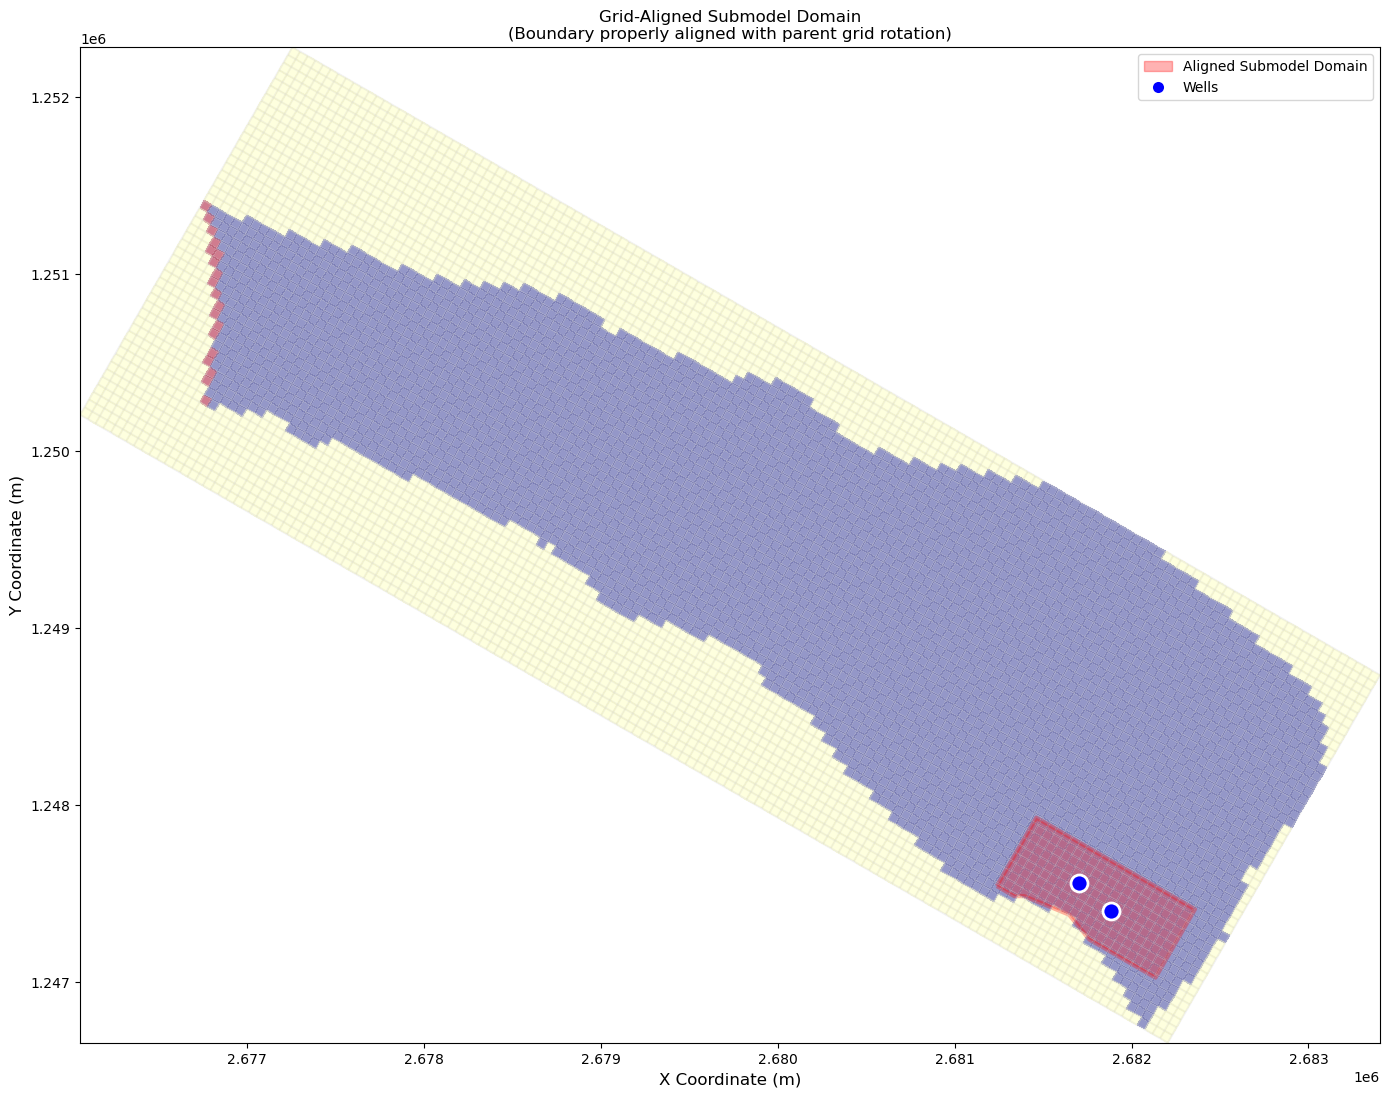

In [10]:
# Fix the coordinate system alignment for submodel boundary calculation

# Step 1: Get parent model grid parameters
parent_xll = parent_modelgrid.xoffset  # or xll 
parent_yll = parent_modelgrid.yoffset  # or yll
parent_rotation = parent_modelgrid.angrot

print(f"Parent model grid parameters:")
print(f"  Origin (xll, yll): ({parent_xll:.1f}, {parent_yll:.1f})")
print(f"  Rotation angle: {parent_rotation} degrees")

# Step 2: Convert wells from real-world to local model coordinates
# This removes the rotation and offset, putting wells in the model's local coordinate system
wells_local_coords = []
for idx, well in wells_gdf.iterrows():
    # Use FloPy's built-in coordinate transformation
    local_x, local_y = parent_modelgrid.get_local_coords(well.geometry.x, well.geometry.y)
    wells_local_coords.append((local_x, local_y))
    print(f"Well {well.get('GWR_ID', idx)}: ({well.geometry.x:.1f}, {well.geometry.y:.1f}) -> local ({local_x:.1f}, {local_y:.1f})")

# Step 3: Calculate submodel bounds in local coordinates
wells_local_x = [coord[0] for coord in wells_local_coords]
wells_local_y = [coord[1] for coord in wells_local_coords]

local_well_x_min = min(wells_local_x)
local_well_x_max = max(wells_local_x)
local_well_y_min = min(wells_local_y)  
local_well_y_max = max(wells_local_y)

print(f"\nWells extent in local coordinates:")
print(f"  X: [{local_well_x_min:.1f}, {local_well_x_max:.1f}]")
print(f"  Y: [{local_well_y_min:.1f}, {local_well_y_max:.1f}]")

# Step 4: Add buffers in local coordinates
submodel_local_xmin = local_well_x_min - downstream_buffer_m
submodel_local_xmax = local_well_x_max + upstream_buffer_m
submodel_local_ymin = local_well_y_min - south_buffer_m  
submodel_local_ymax = local_well_y_max + north_buffer_m

print(f"\nSubmodel bounds in local coordinates (with buffers):")
print(f"  X: [{submodel_local_xmin:.1f}, {submodel_local_xmax:.1f}]")
print(f"  Y: [{submodel_local_ymin:.1f}, {submodel_local_ymax:.1f}]")

# Step 5: Convert submodel boundary back to real-world coordinates
# Create corner points in local coordinates
local_corners = [
    (submodel_local_xmin, submodel_local_ymin),  # SW
    (submodel_local_xmax, submodel_local_ymin),  # SE  
    (submodel_local_xmax, submodel_local_ymax),  # NE
    (submodel_local_xmin, submodel_local_ymax),  # NW
]

# Transform back to real-world coordinates
real_world_corners = []
for local_x, local_y in local_corners:
    real_x, real_y = parent_modelgrid.get_coords(local_x, local_y)
    real_world_corners.append((real_x, real_y))
    
print(f"\nSubmodel corners in real-world coordinates:")
for i, (x, y) in enumerate(real_world_corners):
    corners = ['SW', 'SE', 'NE', 'NW']
    print(f"  {corners[i]}: ({x:.1f}, {y:.1f})")

# Step 6: Create the properly aligned submodel boundary polygon
# Close the polygon by adding the first point at the end
real_world_boundary_coords = real_world_corners + [real_world_corners[0]]
submodel_boundary_poly = Polygon(real_world_boundary_coords)

# Step 7: Clip hte submodel boundary to the parent model boundary
parent_model_boundary_file = download_named_file(
    name='model_boundary',
    data_type='gis'
)
parent_model_boundary = gpd.read_file(parent_model_boundary_file)
# Clip
clipped_submodel_boundary = submodel_boundary_poly.intersection(parent_model_boundary.geometry[0])

# Create GeoDataFrame for the aligned submodel boundary
submodel_boundary_gdf = gpd.GeoDataFrame(
    [{'geometry': clipped_submodel_boundary, 'name': 'submodel_domain_aligned'}],
    crs=parent_modelgrid.crs
)

print(f"\nAligned submodel boundary created:")
print(f"  Area: {clipped_submodel_boundary.area / 1e6:.2f} km²")
print(f"  Perimeter: {clipped_submodel_boundary.length / 1e3:.2f} km")

# Visualize the corrected alignment
fig, ax = plt.subplots(figsize=(14, 12))

# Plot parent model
pmv = flopy.plot.PlotMapView(model=m_parent_base, modelgrid=parent_modelgrid, ax=ax)
pmv.plot_grid(color='lightgrey', alpha=0.3)
pmv.plot_array(m_parent_base.bas6.ibound.array, alpha=0.3, cmap='RdYlBu', vmin=-1, vmax=1)

# Plot aligned submodel boundary
submodel_boundary_gdf.plot(ax=ax, facecolor='red', alpha=0.3, edgecolor='red', 
                          linewidth=3, label='Aligned Submodel Domain')

# Plot wells
wells_gdf.plot(ax=ax, color='blue', markersize=150, label='Wells', zorder=5,
               edgecolors='white', linewidth=2)

# Add corner labels
# for i, (x, y) in enumerate(real_world_corners):
#     corners = ['SW', 'SE', 'NE', 'NW'] 
#     ax.annotate(f'{corners[i]}\n({x:.0f}, {y:.0f})',
#                 xy=(x, y), xytext=(10, 10), textcoords='offset points',
#                 fontsize=9, bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))

legend_handles = [
    mpatches.Patch(color='red', alpha=0.3, label='Aligned Submodel Domain'),
    mlines.Line2D([], [], marker='o', color='blue', markeredgecolor='white', 
                  markeredgewidth=2, markersize=10, linestyle='None', label='Wells')
]
ax.set_title('Grid-Aligned Submodel Domain\n(Boundary properly aligned with parent grid rotation)')
ax.set_xlabel('X Coordinate (m)', fontsize=12)
ax.set_ylabel('Y Coordinate (m)', fontsize=12)
ax.legend(handles=legend_handles)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

#### 2.4.3 Generate Refined Grid Using Notebook 4 Workflow

Now we'll apply the exact same grid generation workflow from notebook 4, using our submodel boundary polygon as the domain definition. This ensures consistency with the established methodology.

##### Rotate the submodel boundary polygon for regular grid alignment

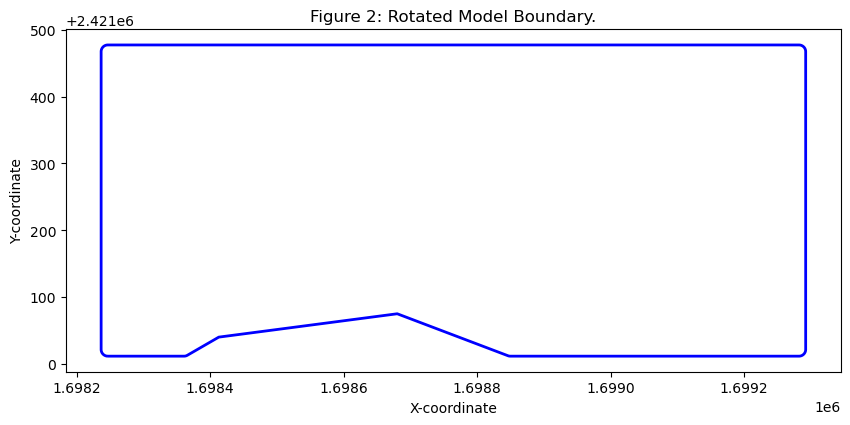

In [11]:
# Buffer the model boundary gdf
submodel_boundary_gdf['geometry'] = submodel_boundary_gdf['geometry'].buffer(10)

# Define the rotation angle in degrees
grid_rotation_angle = 30  # degrees, identified by trial and error, you can adjust this angle to minimize the number of cells outside the boundary
origin_rotation = Point(0, 0)  # Origin for rotation, can be adjusted as needed
# Rotate the model boundary polygon
submodel_boundary_gdf_rotated = submodel_boundary_gdf.copy()

submodel_boundary_gdf_rotated['geometry'] = submodel_boundary_gdf_rotated['geometry'].apply(
    lambda geom: rotate(geom, grid_rotation_angle, origin=origin_rotation)
)
# Get the bounding box of the rotated geometry
xmin_rotated, ymin_rotated, xmax_rotated, ymax_rotated = submodel_boundary_gdf_rotated.total_bounds
# Plot the rotated boundary to verify
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
submodel_boundary_gdf_rotated.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
ax.set_title("Figure 2: Rotated Model Boundary.")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

##### Create Sub-model Grid 

Rotated Grid: 211 columns, 94 rows


Text(0.5, 1.0, 'Figure 3: Rotated FloPy Grid with Rotated Boundary.')

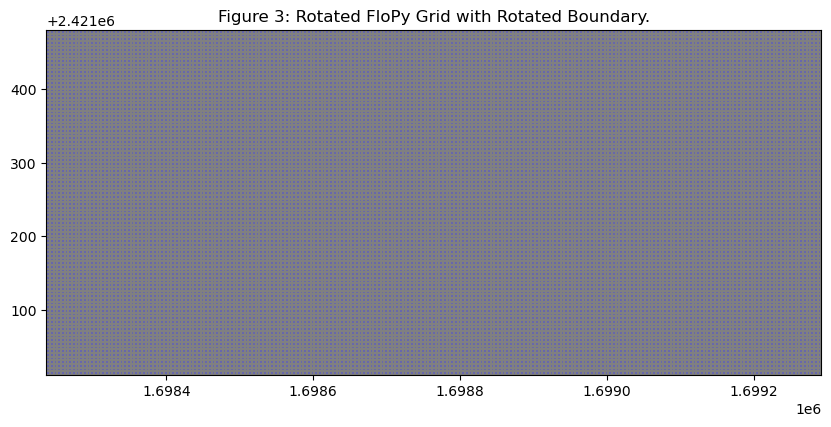

In [12]:
# --- 2. Creation of a new Model Grid based on the rotated Model Boundary ---
# We now have new bounding box coordinates for the rotated model boundary. 
# These we need to rotate back to the original coordinate system to create a
# regular grid that fits the rotated boundary.
# We use the rotated bounding box to define the grid dimensions.
# Calculate the new grid dimensions based on the rotated bounding box
width_rotated = xmax_rotated - xmin_rotated
height_rotated = ymax_rotated - ymin_rotated

# Calculate the number of rows and columns based on the rotated bounding box
ncol_rotated = int(np.ceil(width_rotated / sub_cell_size)) - 1 # Based on visual inspection of rotated grid.
nrow_rotated = int(np.ceil(height_rotated / sub_cell_size))

# Compare number of rows and columns with the original grid
print(f"Rotated Grid: {ncol_rotated} columns, {nrow_rotated} rows")

# Define the delr and delc for the rotated grid
delr_rotated = np.full(ncol_rotated, sub_cell_size)
delc_rotated = np.full(nrow_rotated, sub_cell_size)
nlay = parent_modelgrid.nlay

# Plot the rotated grid and the rotated boundary to verify
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Create a new StructuredGrid with the rotated dimensions
rotated_grid = StructuredGrid(
    delr=delr_rotated,
    delc=delc_rotated,
    top=np.ones((nrow_rotated, ncol_rotated)) * 100,  # Example top elevation
    botm=np.ones((nlay, nrow_rotated, ncol_rotated)) * 50,  # Example bottom elevation
    xoff=xmin_rotated,  # Use the lower-left of the rotated extent
    yoff=ymin_rotated,  # Use the lower-left of the rotated extent
    angrot=0,  # We are currently in the rotated coordinate system, so no additional rotation is needed
    lenuni=2,  # Length unit code: 2 for meters
    crs=submodel_boundary_gdf_rotated.crs.to_string()  # Automatically get CRS from geopackage
)
pmv = flopy.plot.PlotMapView(modelgrid=rotated_grid, ax=ax)
pc = pmv.plot_array(rotated_grid.top, alpha=0.5, cmap='terrain')
pmv.plot_grid()
ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio
ax.set_title("Figure 3: Rotated FloPy Grid with Rotated Boundary.")

##### Rotate the new submodel grid to align with parent grid rotation

Original coordinates after inverse rotation:
xmin: 2681221.66, ymin: 1247538.85
xmax: 2682369.13, ymax: 1247414.83
Corrected grid lower-left corner:
xll = 2681221.66
yll = 1247538.85
Number of cells in the rotated grid: 19834
Total number of active cells in the grid: 18888
Model grid created with the following parameters:
xll:2681221.6585597303; yll:1247538.8510281271; rotation:-30; crs:EPSG:2056; units:meters; lenuni:2


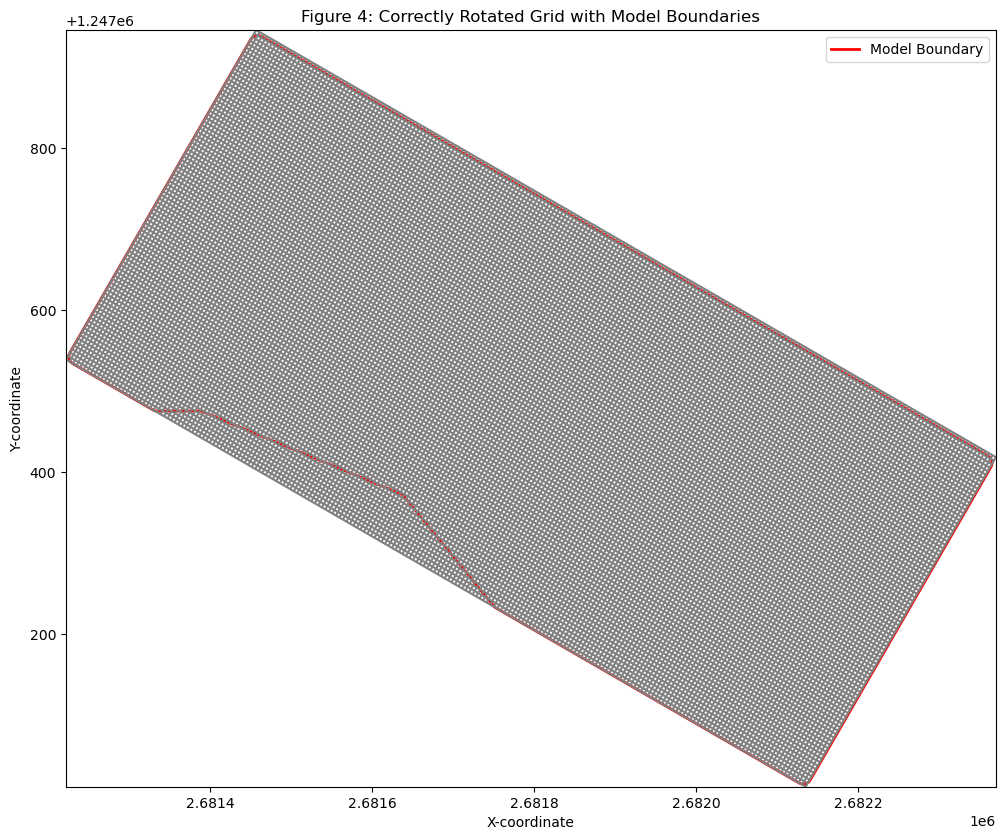

In [13]:
# --- 3. Rotation of the new Model Grid in the CH Coordinate System ---
# Now we need to rotate the lower-left corner of the rotated grid back to the 
# original coordinate system.
# The lower-left corner of the rotated bounding box
# Create points from the rotated bounding box coordinates
min_point_rotated = Point(xmin_rotated, ymin_rotated)
max_point_rotated = Point(xmax_rotated, ymax_rotated)

# Apply inverse rotation (negative angle) around the same origin
min_point_original = rotate(min_point_rotated, -grid_rotation_angle, 
                            origin=origin_rotation)
max_point_original = rotate(max_point_rotated, -grid_rotation_angle, 
                            origin=origin_rotation)

# Extract the coordinates
xmin_original = min_point_original.x
ymin_original = min_point_original.y
xmax_original = max_point_original.x
ymax_original = max_point_original.y

print(f"Original coordinates after inverse rotation:")
print(f"xmin: {xmin_original:.2f}, ymin: {ymin_original:.2f}")
print(f"xmax: {xmax_original:.2f}, ymax: {ymax_original:.2f}")

xll = xmin_original
yll = ymin_original

print(f"Corrected grid lower-left corner:")
print(f"xll = {xll:.2f}")
print(f"yll = {yll:.2f}")
print(f"Number of cells in the rotated grid: {nrow_rotated * ncol_rotated * nlay}")

# Create the FloPy structured grid with the rotated bounding box
sub_modelgrid = StructuredGrid(
    delr=delr_rotated,
    delc=delc_rotated,
    xoff=xmin_original,  # Use the lower-left of the rotated extent
    yoff=ymin_original,  # Use the lower-left of the rotated extent
    angrot=-grid_rotation_angle,  # Apply the desired rotation to the grid
    lenuni=2,  # Length unit code: 2 for meters
    crs=submodel_boundary_gdf.crs.to_string()  # Automatically get CRS from geopackage
)

# Update grid polygons, tag active cells (≥50% inside), and get IBOUND
grid_gdf, ibound = grid_utils.build_grid_gdf_and_ibound(
    modelgrid=sub_modelgrid,
    boundary_gdf=submodel_boundary_gdf,        # your boundary GeoDataFrame
    frac_threshold=0.5,      # change if needed
    nlay=nlay                 # use your model's nlay
)
# Count the number of active cells
active_cells = ibound[ibound > 0].sum()
print(f"Total number of active cells in the grid: {active_cells}")

print("Model grid created with the following parameters:")
print(sub_modelgrid)

# Plot the rotated grid and the model_boundary to check alignment
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=sub_modelgrid, ax=ax)
pmv.plot_grid() 
submodel_boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Model Boundary')
ax.legend(handles=[red_line], loc='upper right')
ax.set_title("Figure 4: Correctly Rotated Grid with Model Boundaries")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()
ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio

##### Export submodel grid to shapefile for visualization

In [14]:
# Export the model grid to shapefile
# Create a list to store grid cell polygons
grid_cells = []

# Get grid cell vertices using FloPy's grid functionality
for i in range(sub_modelgrid.nrow):
    for j in range(sub_modelgrid.ncol):
        # Get cell vertices
        cell_vertices = sub_modelgrid.get_cell_vertices(i, j)

        # Create polygon from vertices
        cell_polygon = Polygon(cell_vertices)
        
        # Store cell information
        grid_cells.append({
            'row': i,
            'col': j,
            'cell_id': f"{i}_{j}",
            'geometry': cell_polygon,
            'x': sub_modelgrid.xcellcenters[i, j],
            'y': sub_modelgrid.ycellcenters[i, j]
        })

# Create GeoDataFrame
grid_gdf = gpd.GeoDataFrame(grid_cells, crs=sub_modelgrid.crs)

# Export to GeoPackage
grid_geopackage_path = os.path.join(grids_ws, 'sub_model_grid.gpkg')
grid_gdf.to_file(grid_geopackage_path, driver='GPKG', layer='sub_model_grid')

print(f"Model grid exported to: {grid_geopackage_path}")

Model grid exported to: /Users/bea/applied_groundwater_modelling_data/limmat/case_study_group_0/grids/sub_model_grid.gpkg


### 2.5 Downscale Parent Model to Submodel Grid
Now we will extract model geometry, parameters, and boundary conditions from the parent model to set up the submodel. This includes interpolating aquifer properties and extracting heads for boundary conditions. We will go through each package and ensure the submodel is properly configured.

#### 2.5.1 DIS Package (Model Geometry)
We will start by configuring the DIS package for the submodel, ensuring that the model geometry matches the refined grid we created earlier and is consistent with the parent DIS package. Let's remember what we define in the DIS package:
- Number of layers, rows, columns
- Cell dimensions (delr, delc)
- Top and bottom elevations
- Time discretization (steady-state or transient)

Remember that you can always check the FloPy documentation for help on any package by using the help function. For example, to get help on the DIS package, you can use:
```python
help(flopy.modflow.mfdis.ModflowDis)
```

##### Model Top
We start with the model top. We will re-import the high-resolution DEM to define the model top for the submodel.

swissalti3d_merged_lv95.tif already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
swissalti3d_merged_lv95_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
DEM loaded:
  CRS: EPSG:2056
  Bounds: (2675999.9127667537, 2683999.9575791946, 1246000.03021355, 1252000.0638228806)
Resampling DEM to submodel grid...
DEM resampling completed in 3.08 seconds
  Elevation range: 403.1 to 417.6 m


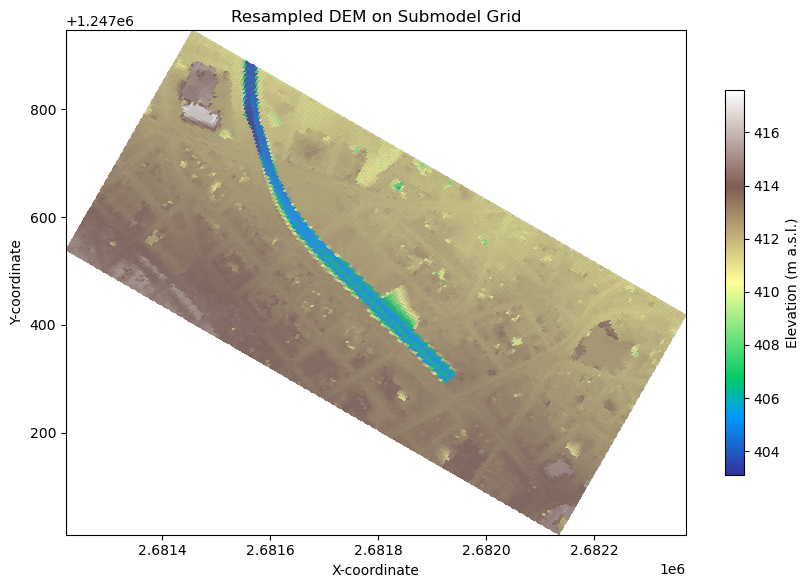

In [15]:
# Load and resample DEM to submodel grid (following notebook 4)
dem_path = download_named_file('dem_hres', data_type='gis')
rio = flopy.utils.Raster.load(dem_path)

print(f"DEM loaded:")
print(f"  CRS: {rio.crs}")
print(f"  Bounds: {rio.bounds}")

# Resample DEM to submodel grid
print("Resampling DEM to submodel grid...")
import time
t0 = time.time()
submodel_top = rio.resample_to_grid(sub_modelgrid, band=rio.bands[0], method="nearest")
resample_time = time.time() - t0

# Clean up the resampled data
submodel_top = np.round(submodel_top, 1)  # Round to 10 cm
valid = np.isfinite(submodel_top) & (submodel_top > 0)

if not np.any(valid):
    raise RuntimeError("No valid DEM data found in submodel area")

print(f"DEM resampling completed in {resample_time:.2f} seconds")
print(f"  Elevation range: {submodel_top[valid].min():.1f} to {submodel_top[valid].max():.1f} m")

# Plot the submodel_top on the submodel grid
fig, ax = plt.subplots(figsize=(10, 10))
pmv = flopy.plot.PlotMapView(modelgrid=sub_modelgrid, ax=ax)
im = pmv.plot_array(submodel_top, cmap='terrain', vmin=np.nanmin(submodel_top), vmax=np.nanmax(submodel_top))
pmv.plot_grid(color='grey', alpha=0.2)
cbar = plt.colorbar(im, ax=ax, shrink=0.5)
cbar.set_label('Elevation (m a.s.l.)')
ax.set_title('Resampled DEM on Submodel Grid')
ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

##### Model Bottom
We will follow the example in Notebook 4 to define the model bottom for the submodel. We will use the same approach to ensure consistency. The model bottom is calculated as the groundwater table minus the aquifer thickness.

Grundwasservorkommen_-OGD.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Grundwasservorkommen_-OGD_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Original isohypses: 339 features
Clipped isohypses: 23 features
Using column 'LABEL' for elevation values
Interpolating groundwater elevations...
=== STEP 1: Densifying Contour Network ===
Using 12 original contours
Original thickness range: 2.0 - 60.0 m
Creating intermediate contours for levels: [ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36.
 38. 40. 42. 44. 46. 48. 50. 52. 54. 56. 58. 60.]
Using 1833 points from original contours for surface interpolation
Interpolating thickness surface...
Generating intermediate contour lines...
Error extracting contour paths: 'QuadContourSet' object has no attribute 'collections'
Falling back to alternative contour generation method...
Successfully created 2725 densified contours
Created 2725 total contours

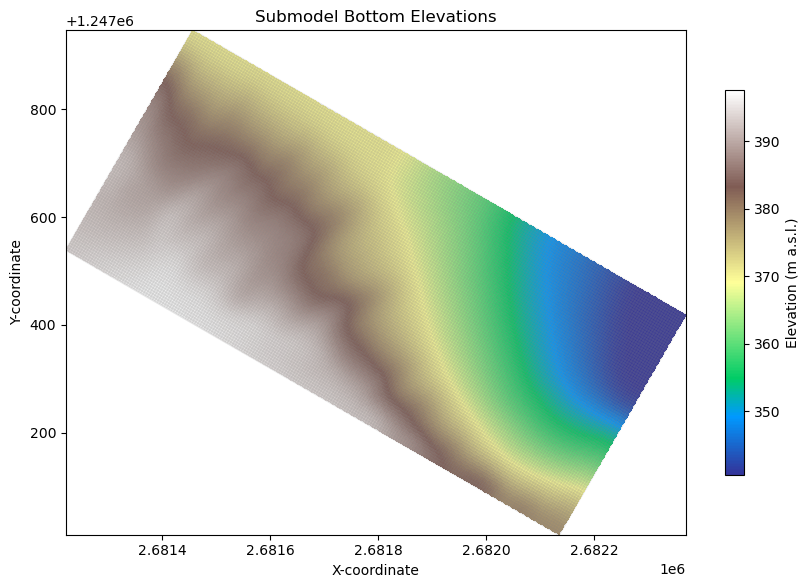

In [16]:
# Define submodel bottom based on groundwater levels and aquifer thickness
# Load groundwater levels from file & interpolate to submodel grid
isolines = download_named_file('groundwater_map_norm', data_type='gis')
gdf_isolines = gpd.read_file(isolines, layer='GS_GW_ISOHYPSE_MW_L')
gw_elevations = grid_utils.interpolate_isohypses_to_grid(gdf_isolines, sub_modelgrid)

'''# Optional, plot gw_elevations for verification
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(gw_elevations, extent=sub_modelgrid.extent, origin='upper', cmap='Blues')
ax.set_title("Figure 5: Interpolated Groundwater Elevations on Submodel Grid")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
plt.colorbar(im, ax=ax, label="Groundwater Elevation (m a.s.l.)")
ax.set_aspect('equal', adjustable='box')
plt.show()'''

# Load groundwater thickness from file, requires 4_model_implementation.ipynb to have been run once first
workspace = os.path.join(get_default_data_folder(), 'limmat_valley_model')
thickness_path = os.path.join(workspace, 'aquifer_thickness_contours.gpkg')
aquifer_thickness_gdf = gpd.read_file(thickness_path, layer='aquifer_thickness_contours')
# Interpolate aquifer thickness to submodel grid
aquifer_thickness_resampled = grid_utils.interpolate_aquifer_thickness_to_grid_with_contour_densification(
    contour_gdf=aquifer_thickness_gdf,
    modelgrid=sub_modelgrid,
    thickness_column='aquifer_thickness',
    contour_interval=2.0,  # Create intermediate contours every 2m
    plot_intermediate=False,  # Show the contour densification step
    plot_points=False,  # Set to True if you want to see final interpolation points
    buffer_distance=300
)
# Smooth the resampled aquifer thickness to remove small-scale noise
from scipy.ndimage import gaussian_filter
aquifer_thickness_resampled = gaussian_filter(aquifer_thickness_resampled, sigma=4)

'''# Plot aquifer thickness for verification
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(aquifer_thickness_resampled, extent=sub_modelgrid.extent, origin='upper', cmap='YlOrBr')
ax.set_title("Figure 6: Interpolated Aquifer Thickness on Submodel Grid")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
plt.colorbar(im, ax=ax, label="Aquifer Thickness (m)")
ax.set_aspect('equal', adjustable='box')
plt.show()'''

# Calculate bottom elevation
submodel_bottom = gw_elevations - aquifer_thickness_resampled

# Ensure bottom is 3D array format
if submodel_bottom.ndim == 2:
    submodel_bottom = submodel_bottom[np.newaxis, :, :]

print(f"Submodel bottom calculated:")
print(f"  Bottom range: {submodel_bottom[0][valid].min():.1f} to {submodel_bottom[0][valid].max():.1f} m")

# Define the delr and delc for the submodel grid
delr = np.full(sub_modelgrid.ncol, sub_cell_size)
delc = np.full(sub_modelgrid.nrow, sub_cell_size)

# Update the submodel grid with real elevations
submodel_grid = StructuredGrid(
    delr=delr,
    delc=delc,
    top=submodel_top,
    botm=submodel_bottom,
    nlay=nlay,
    xoff=xll,
    yoff=yll,
    angrot=-grid_rotation_angle
)

print("Submodel grid updated with DEM elevations")

# Plot the final submodel grid with bottom elevations
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
pmv = flopy.plot.PlotMapView(modelgrid=submodel_grid, ax=ax)
im = pmv.plot_array(submodel_grid.botm, cmap='terrain', vmin=np.nanmin(submodel_grid.botm), vmax=np.nanmax(submodel_grid.botm))
pmv.plot_grid(color='grey', alpha=0.2)
cbar = plt.colorbar(im, ax=ax, shrink=0.5)
cbar.set_label('Elevation (m a.s.l.)')
ax.set_title('Submodel Bottom Elevations')
ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

##### Initiate sub_base model and write submodel DIS package

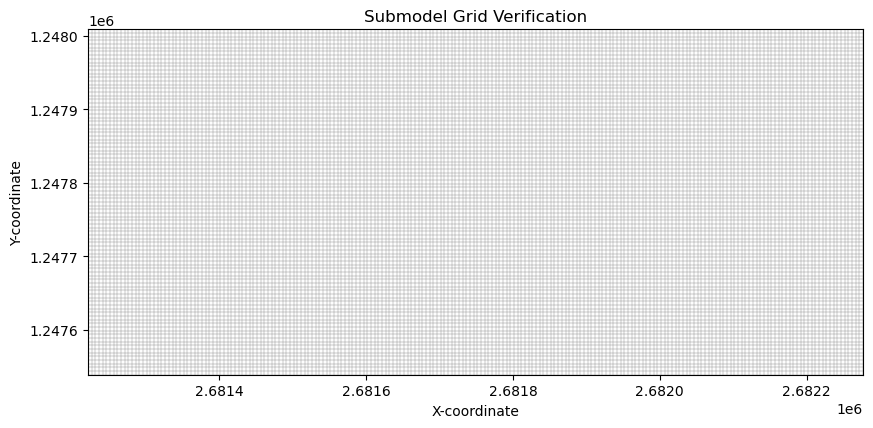

In [17]:
# Create the sub_base model
m_sub_base = flopy.modflow.Modflow(
    namefile.replace('.nam', ''), 
    model_ws=sub_base_ws,
    version='mfnwt',
    exe_name='mfnwt.exe'  # Ensure the executable is correctly specified
)

# Get temporal parameters from parent model
nper = m_parent_base.dis.nper
perlen = m_parent_base.dis.perlen.array
nstp = m_parent_base.dis.nstp.array
tsmult = m_parent_base.dis.tsmult.array # Time step multiplier
steady = m_parent_base.dis.steady.array

sub_base_dis = flopy.modflow.ModflowDis(
    model=m_sub_base,
    model_ws=sub_base_ws,
    nlay=nlay,
    nrow=sub_modelgrid.nrow,
    ncol=sub_modelgrid.ncol,
    delr=delr,
    delc=delc,
    xul=xll,
    yul=yll + (sub_modelgrid.nrow * sub_cell_size),  # Upper-left y-coordinate
    angrot=-grid_rotation_angle,
    crs=sub_modelgrid.crs.to_string(),
    top=submodel_top,
    botm=submodel_bottom,
    nper=nper,
    perlen=perlen,
    nstp=nstp,
    tsmult=tsmult,
    steady=steady,
    itmuni=4,  # Time unit: days
    lenuni=2,  # Length unit: meters
)

# Plot sub_base_grid for verification
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
pmv = flopy.plot.PlotMapView(model=m_sub_base, ax=ax)
pmv.plot_grid(color='grey', alpha=0.2)
ax.set_title("Submodel Grid Verification")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio
plt.show()


#### 2.5.2 BAS Package (Initial Heads)
We will set up the BAS package for the submodel, ensuring that the initial heads are consistent with the parent model. We will extract the steady-state heads from the parent model and interpolate them to the submodel grid.

##### Extract boundary heads from parent model

We'll extract head values along the submodel boundary from the parent model results. These will become constant head (CHD) boundary conditions along all lateral boundaries of the submodel, ensuring proper nesting within the parent model domain. 

In [18]:
# Extract parent model heads for boundary interpolation
print("Extracting parent model heads for boundary condition interpolation...")

# Load parent model heads
parent_hds_path = os.path.join(parent_base_ws, f"{m_parent_base.name}.hds")
if not os.path.exists(parent_hds_path):
    print("Parent model heads file not found. Running parent model...")
    success, buff = m_parent_base.run_model(silent=True, report=True)
    if not success:
        raise RuntimeError("Parent model failed to run")
    print("✓ Parent model run completed")

# Load parent heads
headobj_parent = flopy.utils.HeadFile(parent_hds_path)
parent_heads = headobj_parent.get_data()[0]  # Layer 0, stress period 0

# Get parent model grid coordinates and active cells
parent_ibound = m_parent_base.bas6.ibound.array[0]  # Layer 0
parent_active_mask = parent_ibound == 1

# Extract coordinates of active parent cells
parent_x_centers = parent_modelgrid.xcellcenters[parent_active_mask]
parent_y_centers = parent_modelgrid.ycellcenters[parent_active_mask]
parent_heads_active = parent_heads[parent_active_mask]

# Filter out any invalid heads (NaN, inf, or unrealistic values)
valid_head_mask = (np.isfinite(parent_heads_active) & 
                   (parent_heads_active > 300) &  # Reasonable lower bound for elevation
                   (parent_heads_active < 600))   # Reasonable upper bound for elevation

parent_coords_valid = np.column_stack([
    parent_x_centers[valid_head_mask],
    parent_y_centers[valid_head_mask]
])
parent_heads_valid = parent_heads_active[valid_head_mask]

print(f"Parent model head extraction:")
print(f"  Total parent cells: {parent_heads.size:,}")
print(f"  Active parent cells: {np.sum(parent_active_mask):,}")
print(f"  Valid heads for interpolation: {len(parent_heads_valid):,}")
print(f"  Head range: {parent_heads_valid.min():.1f} to {parent_heads_valid.max():.1f} m")

# Create KDTree for efficient nearest neighbor search
from scipy.spatial import cKDTree
parent_tree = cKDTree(parent_coords_valid)

print("✓ Parent model heads prepared for boundary interpolation")

Extracting parent model heads for boundary condition interpolation...
Parent model head extraction:
  Total parent cells: 6,816
  Active parent cells: 4,205
  Valid heads for interpolation: 4,205
  Head range: 390.2 to 412.7 m
✓ Parent model heads prepared for boundary interpolation


##### Get IBOUND array for submodel

Creating complete CHD boundary around submodel domain...
Complete boundary detection results:
  Total boundary cells: 2402
  CHD cells: 2,402
  Active cells: 17,432
Interpolating heads for all boundary cells...
Complete CHD data created: 2402 cells


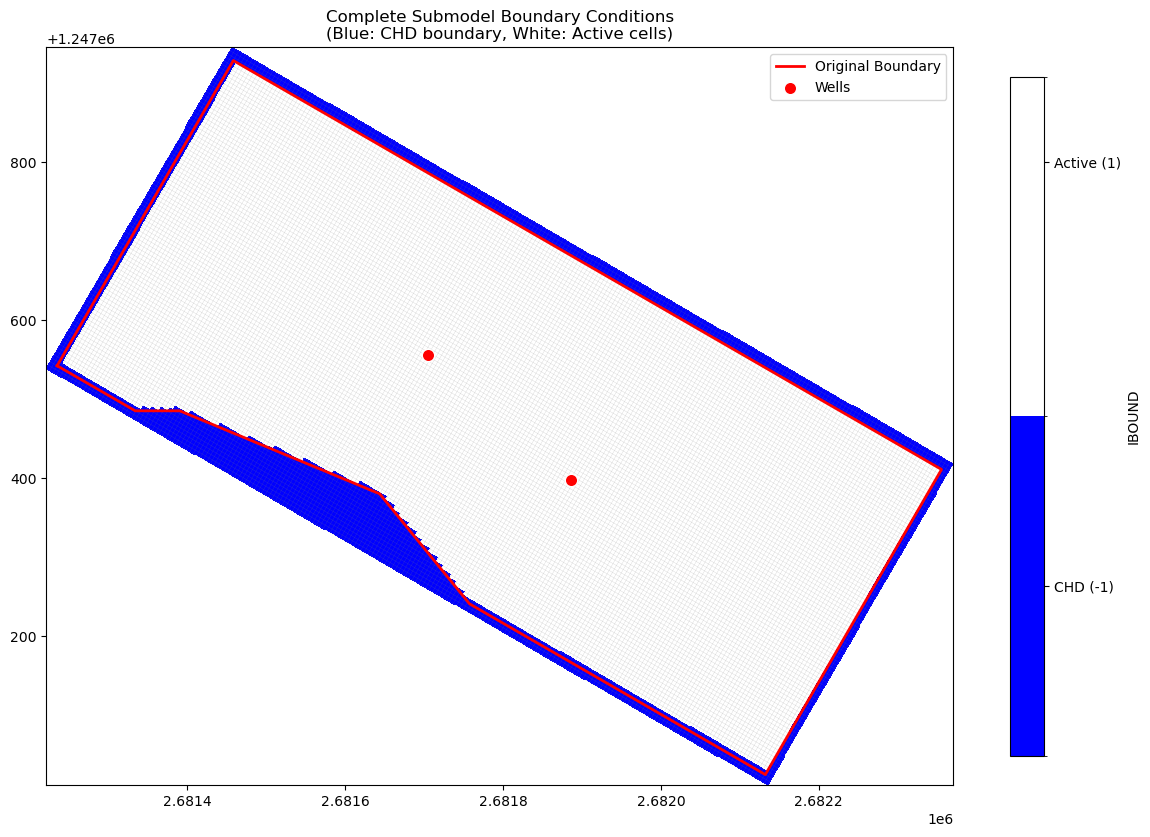

✓ Complete CHD boundary created around entire submodel domain


In [19]:
# Create complete CHD boundary
def create_complete_boundary_ibound(submodel_grid, boundary_polygon, boundary_thickness=1):
    """
    Create IBOUND array with complete CHD boundary around submodel domain.
    
    Parameters:
    -----------
    submodel_grid : flopy.discretization.StructuredGrid
        Submodel grid
    boundary_polygon : shapely.geometry.Polygon
        Clipped boundary polygon
    boundary_thickness : int
        Number of cell layers to mark as CHD from domain edge
    
    Returns:
    --------
    ibound : numpy.ndarray
        IBOUND array with CHD boundaries
    boundary_cells : list
        List of boundary cell information
    """
    from shapely.geometry import Point
    
    # Initialize IBOUND as all active cells
    ibound = np.ones((nlay, submodel_grid.nrow, submodel_grid.ncol), dtype=int)
    boundary_cells = []
    
    # Method 1: Mark cells outside or on boundary of clipped polygon as CHD
    for i in range(submodel_grid.nrow):
        for j in range(submodel_grid.ncol):
            # Get cell center coordinates
            x_center = submodel_grid.xcellcenters[i, j]
            y_center = submodel_grid.ycellcenters[i, j]
            cell_point = Point(x_center, y_center)
            
            # Check if cell center is outside boundary or very close to boundary
            distance_to_boundary = cell_point.distance(boundary_polygon.boundary)
            
            # Mark as CHD if:
            # 1. Cell is outside the boundary polygon, OR
            # 2. Cell is very close to boundary (within half cell size)
            if (not boundary_polygon.contains(cell_point) or 
                distance_to_boundary < sub_cell_size * 0.5):
                
                # Only mark as CHD if cell has valid coordinates (not completely outside model domain)
                if (submodel_grid.extent[0] <= x_center <= submodel_grid.extent[1] and
                    submodel_grid.extent[2] <= y_center <= submodel_grid.extent[3]):
                    
                    ibound[0, i, j] = -1  # CHD cell
                    boundary_cells.append({
                        'submodel_row': i,
                        'submodel_col': j,
                        'x': x_center,
                        'y': y_center,
                        'distance_to_boundary': distance_to_boundary
                    })
    
    # Method 2: Ensure edge cells are CHD (safety measure)
    edge_thickness = max(1, boundary_thickness)
    
    # Top and bottom edges
    ibound[:, :edge_thickness, :] = -1
    ibound[:, -edge_thickness:, :] = -1
    
    # Left and right edges  
    ibound[:, :, :edge_thickness] = -1
    ibound[:, :, -edge_thickness:] = -1
    
    # Add edge cells to boundary_cells list if not already included
    for i in range(submodel_grid.nrow):
        for j in range(submodel_grid.ncol):
            if ibound[0, i, j] == -1:
                x_center = submodel_grid.xcellcenters[i, j]
                y_center = submodel_grid.ycellcenters[i, j]
                
                # Check if this cell is already in boundary_cells
                cell_exists = any(
                    cell['submodel_row'] == i and cell['submodel_col'] == j 
                    for cell in boundary_cells
                )
                
                if not cell_exists:
                    boundary_cells.append({
                        'submodel_row': i,
                        'submodel_col': j,
                        'x': x_center,
                        'y': y_center,
                        'distance_to_boundary': 0.0  # Edge cell
                    })
    
    return ibound, boundary_cells

# Apply the improved boundary detection
print("Creating complete CHD boundary around submodel domain...")
submodel_ibound_complete, boundary_cells_complete = create_complete_boundary_ibound(
    submodel_grid, clipped_submodel_boundary, boundary_thickness=1
)

print(f"Complete boundary detection results:")
print(f"  Total boundary cells: {len(boundary_cells_complete)}")
print(f"  CHD cells: {np.sum(submodel_ibound_complete == -1):,}")
print(f"  Active cells: {np.sum(submodel_ibound_complete == 1):,}")

# Improved head interpolation for all boundary cells
print("Interpolating heads for all boundary cells...")

# Use the same KDTree approach but for all boundary cells
sub_boundary_coords_complete = []
for cell in boundary_cells_complete:
    sub_boundary_coords_complete.append([cell['x'], cell['y']])

sub_boundary_coords_complete = np.array(sub_boundary_coords_complete)

# Perform inverse distance weighted interpolation
k_neighbors = min(5, len(parent_heads_valid))
distances, neighbor_indices = parent_tree.query(sub_boundary_coords_complete, k=k_neighbors)

# Handle zero distances
distances = np.maximum(distances, 1e-10)

# Calculate weights
weights = 1.0 / distances
weights = weights / weights.sum(axis=1, keepdims=True)

# Weighted average
interpolated_heads_complete = np.sum(
    parent_heads_valid[neighbor_indices] * weights, axis=1
)

# Create CHD package data for all boundary cells
chd_data_complete = []
for i, cell in enumerate(boundary_cells_complete):
    interpolated_head = float(interpolated_heads_complete[i])
    
    chd_data_complete.append([
        0,  # Layer 0
        cell['submodel_row'],
        cell['submodel_col'],
        interpolated_head,
        interpolated_head
    ])

print(f"Complete CHD data created: {len(chd_data_complete)} cells")

# Update variables for consistency with rest of notebook
submodel_ibound_clipped = submodel_ibound_complete
boundary_cells = boundary_cells_complete
submodel_chd_data = chd_data_complete

# Visualize the complete boundary conditions
fig, ax = plt.subplots(figsize=(12, 10))

# Define colormap for IBOUND visualization  
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(['blue', 'white'])  # CHD=-1: blue, Active=1: white
bounds = [-1.5, -0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pmv = flopy.plot.PlotMapView(modelgrid=submodel_grid, ax=ax)
im = pmv.plot_array(submodel_ibound_complete[0], cmap=cmap, norm=norm)
pmv.plot_grid(color='gray', alpha=0.3, linewidth=0.3)

# Plot original clipped boundary for reference
if hasattr(clipped_submodel_boundary, 'exterior'):
    boundary_x, boundary_y = clipped_submodel_boundary.exterior.xy
    ax.plot(boundary_x, boundary_y, 'red', linewidth=2, label='Original Boundary')

# Plot wells
wells_gdf.plot(ax=ax, color='red', markersize=80, label='Wells', zorder=5,
               edgecolors='white', linewidth=1)

# Colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.7, ticks=[-1, 1])
cbar.ax.set_yticklabels(["CHD (-1)", "Active (1)"])
cbar.set_label("IBOUND")

ax.set_title('Complete Submodel Boundary Conditions\n(Blue: CHD boundary, White: Active cells)')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

print("✓ Complete CHD boundary created around entire submodel domain")

##### Write CHD & BAS package 

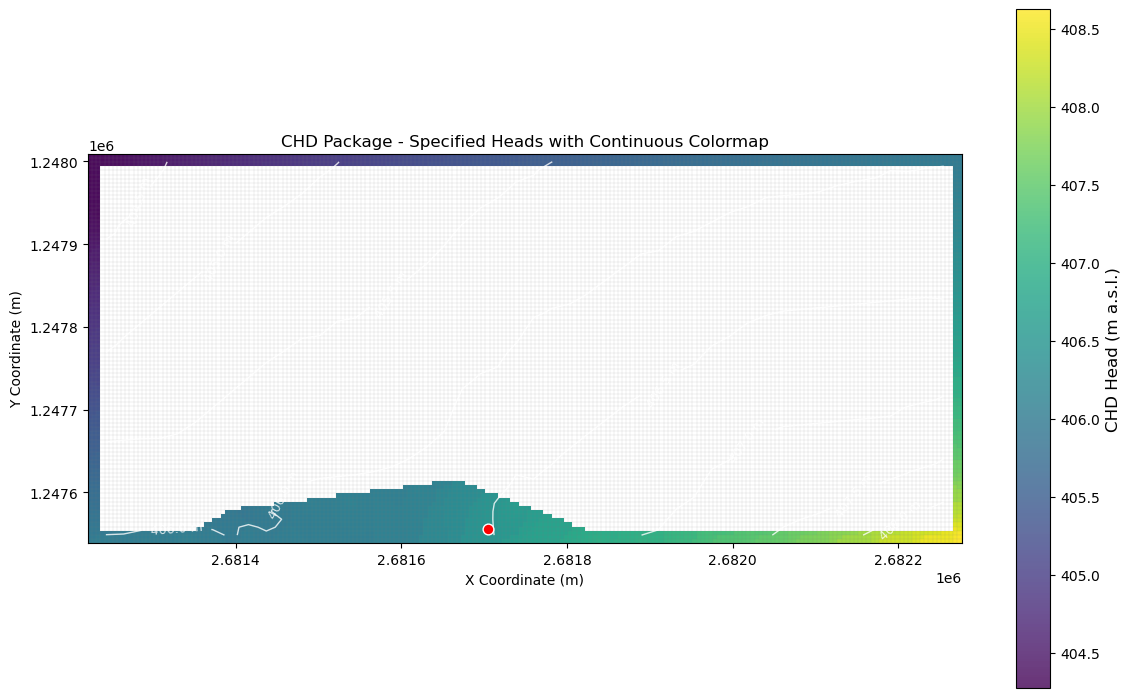

CHD Package Summary:
  Number of CHD cells: 2402
  Head range: 404.27 to 408.63 m
  Mean head: 406.05 m
  Standard deviation: 0.88 m


In [20]:
sub_base_chd = flopy.modflow.ModflowChd(
    model=m_sub_base,
    stress_period_data={0: submodel_chd_data},
    ipakcb=53,
    model_ws=sub_base_ws
)

# Extract CHD package data and visualize with continuous colormap
fig, ax = plt.subplots(figsize=(12, 10))

pmv = flopy.plot.PlotMapView(model=m_sub_base, ax=ax)
pmv.plot_grid(color='gray', alpha=0.3, linewidth=0.3)

# Extract CHD data
chd_package = m_sub_base.chd
chd_data = chd_package.stress_period_data[0]  # First stress period

# Create arrays to hold CHD head values for plotting
chd_array = np.full((m_sub_base.nrow, m_sub_base.ncol), np.nan)
chd_coords_x = []
chd_coords_y = []
chd_heads = []

for chd_cell in chd_data:
    layer, row, col, start_head, end_head = chd_cell
    chd_array[row, col] = start_head
    
    # Also collect coordinates for scatter plot option
    x = m_sub_base.modelgrid.xcellcenters[row, col]
    y = m_sub_base.modelgrid.ycellcenters[row, col]
    chd_coords_x.append(x)
    chd_coords_y.append(y)
    chd_heads.append(start_head)

# Method 1: Plot CHD as array (shows cells as squares)
chd_masked = np.ma.masked_where(np.isnan(chd_array), chd_array)
im = pmv.plot_array(chd_masked, alpha=0.8, cmap='viridis')

# Method 2: Alternative - plot as scatter points (optional, comment out if using array method)
# scatter = ax.scatter(chd_coords_x, chd_coords_y, 
#                     c=chd_heads, 
#                     s=30,  # Size of points
#                     cmap='viridis',
#                     edgecolors='white',
#                     linewidth=0.5,
#                     alpha=0.8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('CHD Head (m a.s.l.)', fontsize=12)

# Add contours of CHD heads for better visualization
if len(chd_heads) > 3:  # Need at least a few points for contouring
    from scipy.interpolate import griddata
    
    # Create a regular grid for interpolation
    xi = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 50)
    yi = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 50)
    xi_grid, yi_grid = np.meshgrid(xi, yi)
    
    # Interpolate CHD values
    zi_grid = griddata((chd_coords_x, chd_coords_y), chd_heads, 
                       (xi_grid, yi_grid), method='linear')
    
    # Add contour lines
    contours = ax.contour(xi_grid, yi_grid, zi_grid, 
                         levels=8, colors='white', linewidths=1, alpha=0.8)
    ax.clabel(contours, inline=True, fontsize=9, fmt='%.1f m')

# Plot wells for reference
if 'wells_gdf' in locals():
    wells_gdf.plot(ax=ax, color='red', markersize=60, label='Wells', zorder=5,
                   edgecolors='white', linewidth=1)

ax.set_title('CHD Package - Specified Heads with Continuous Colormap')
ax.set_xlabel('X Coordinate (m)')
ax.set_ylabel('Y Coordinate (m)')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

# Print CHD statistics
print(f"CHD Package Summary:")
print(f"  Number of CHD cells: {len(chd_data)}")
print(f"  Head range: {min(chd_heads):.2f} to {max(chd_heads):.2f} m")
print(f"  Mean head: {np.mean(chd_heads):.2f} m")
print(f"  Standard deviation: {np.std(chd_heads):.2f} m")

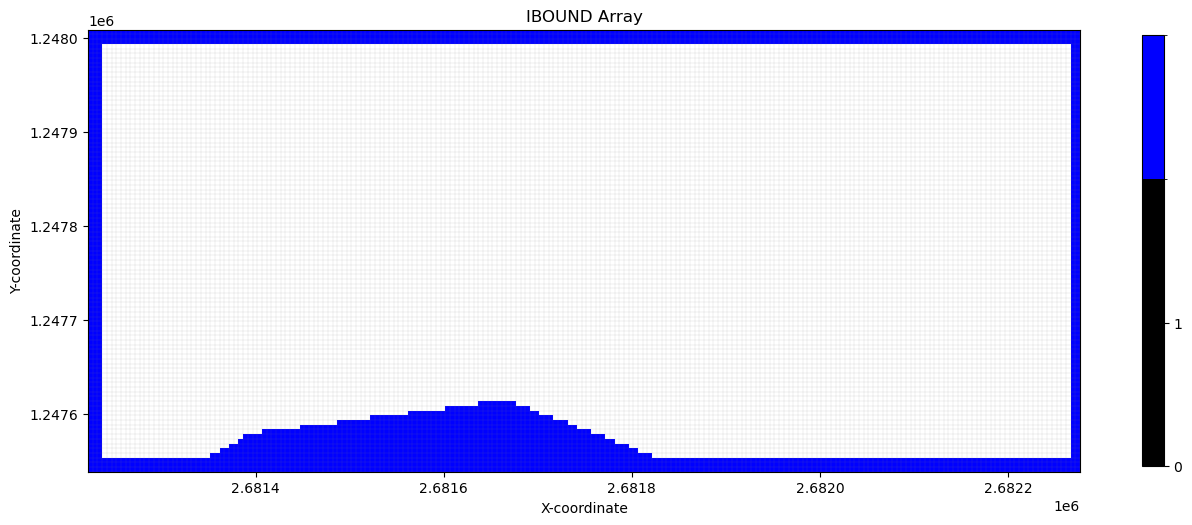

In [21]:
sub_base_bas = flopy.modflow.ModflowBas(m_sub_base, ibound=submodel_ibound_clipped, strt=gw_elevations)

# Plot IBOUND and starting heads
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
pmv = flopy.plot.PlotMapView(model=m_sub_base, ax=ax)
im = pmv.plot_ibound()
plt.colorbar(im, ax=ax, shrink=0.7, ticks=[-1, 0, 1])
pmv.plot_grid(color='gray', alpha=0.3, linewidth=0.3)
ax.set_title('IBOUND Array')
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
ax.set_aspect('equal')   


#### 2.5.3 UPW Package (Aquifer Properties)
We will set up the UPW package for the submodel, ensuring that the aquifer properties are consistent with the parent model. We will extract the hydraulic conductivity and specific storage values from the parent model and interpolate them to the submodel grid.

Parent model aquifer parameters:
  HK range: 0.00 to 30.00 m/day
  VKA range: 0.000100 to 3.000007
Parent model aquifer parameters:
  HK range: 0.00 to 30.00 m/day
  VKA range: 0.000100 to 3.000007
  Active cells in parent model: 4,205

Using uniform parameter values from active parent model cells...
Submodel grid shape: 94 x 211

Representative uniform values from active cells:
  Uniform HK: 20.00 m/day (from 4205 active cells)
  Uniform VKA: 2.000000 (from 4205 active cells)

Submodel aquifer parameters (uniform values, all >0):
  HK: 20.00 to 20.00 m/day (uniform)
  VKA: 2.000000 to 2.000000 (uniform)

Array dimension verification:
  sub_hk shape: (1, 94, 211)
  Expected shape: (1, 94, 211)
  hani_value used: 1.0


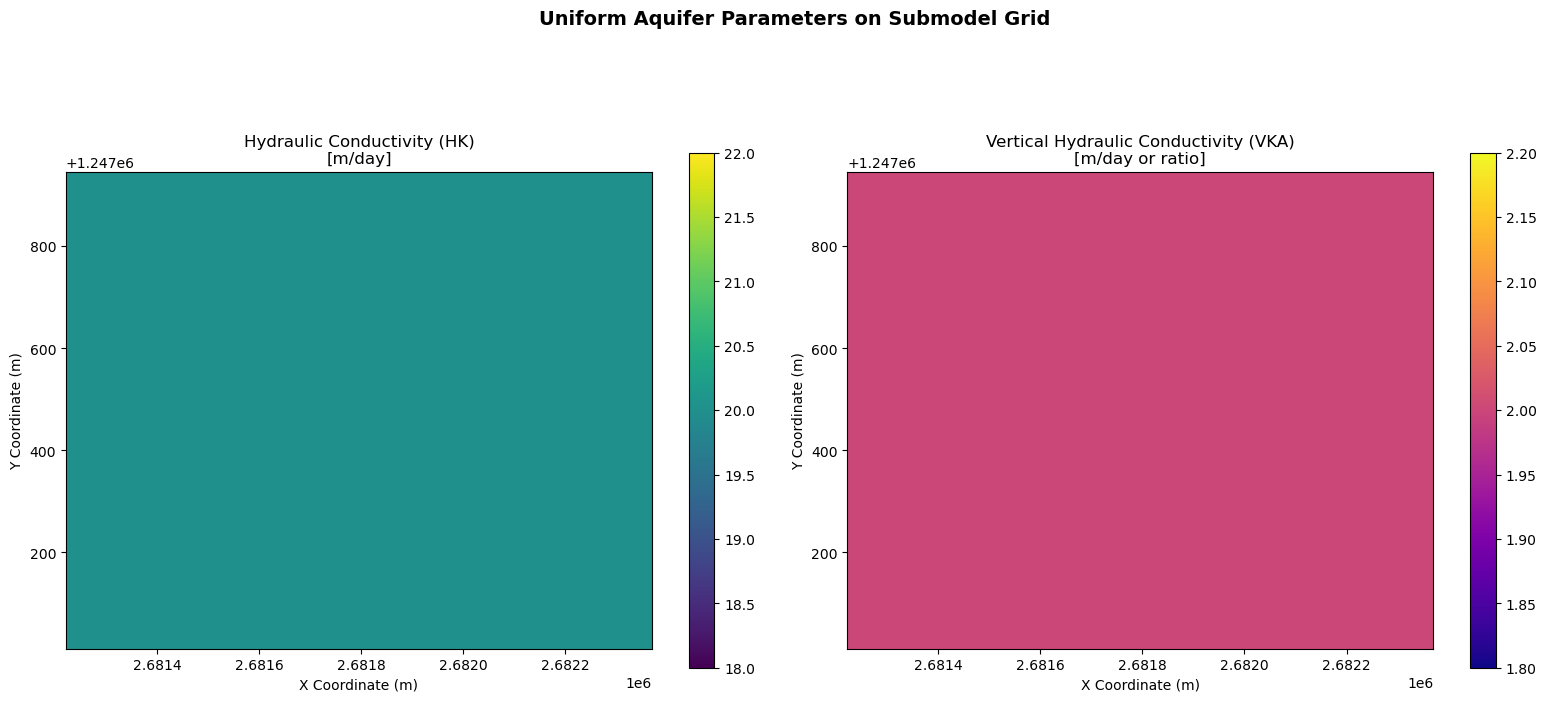

✓ UPW package created with uniform parameters from parent model statistics
✓ All hydraulic conductivity values are >0 and physically realistic


In [22]:
# Get the UPW package from parent model
parent_upw = m_parent_base.upw
parent_ibound = m_parent_base.bas6.ibound.array  # Get parent model IBOUND

# Extract hydraulic conductivity arrays from parent model
parent_hk = parent_upw.hk.array  # Horizontal hydraulic conductivity
parent_vka = parent_upw.vka.array  # Vertical hydraulic conductivity (or anisotropy ratio)
# Only for transient models
# parent_sy = parent_upw.sy.array  # Specific yield
# parent_ss = parent_upw.ss.array  # Specific storage

print(f"Parent model aquifer parameters:")
print(f"  HK range: {parent_hk.min():.2f} to {parent_hk.max():.2f} m/day")
print(f"  VKA range: {parent_vka.min():.6f} to {parent_vka.max():.6f}")# Get the UPW package from parent model
parent_upw = m_parent_base.upw
parent_ibound = m_parent_base.bas6.ibound.array  # Get parent model IBOUND

# Extract hydraulic conductivity arrays from parent model
parent_hk = parent_upw.hk.array  # Horizontal hydraulic conductivity
parent_vka = parent_upw.vka.array  # Vertical hydraulic conductivity (or anisotropy ratio)

print(f"Parent model aquifer parameters:")
print(f"  HK range: {parent_hk.min():.2f} to {parent_hk.max():.2f} m/day")
print(f"  VKA range: {parent_vka.min():.6f} to {parent_vka.max():.6f}")

# Check parent model active cells
if parent_ibound.ndim == 3:
    parent_active_cells = (parent_ibound[0, :, :] == 1).sum()
    active_mask_parent = parent_ibound[0, :, :] == 1
    print(f"  Active cells in parent model: {parent_active_cells:,}")
else:
    parent_active_cells = (parent_ibound == 1).sum()
    active_mask_parent = parent_ibound == 1
    print(f"  Active cells in parent model: {parent_active_cells:,}")

# Use representative uniform values from active parent cells instead of interpolation
print("\nUsing uniform parameter values from active parent model cells...")
print(f"Submodel grid shape: {sub_modelgrid.nrow} x {sub_modelgrid.ncol}")

# Extract statistics from active cells only (exclude zeros and inactive cells)
active_hk = parent_hk[0][active_mask_parent]
active_vka = parent_vka[0][active_mask_parent]

# Filter out zeros and get representative values
valid_hk = active_hk[active_hk > 0]
valid_vka = active_vka[active_vka > 0]

# Use median values for uniform parameters (more robust than mean)
uniform_hk = np.median(valid_hk) if len(valid_hk) > 0 else 20.0  # Default for gravel aquifer
uniform_vka = np.median(valid_vka) if len(valid_vka) > 0 else 2.0  # Default VKA

print(f"\nRepresentative uniform values from active cells:")
print(f"  Uniform HK: {uniform_hk:.2f} m/day (from {len(valid_hk)} active cells)")
print(f"  Uniform VKA: {uniform_vka:.6f} (from {len(valid_vka)} active cells)")

# Create uniform parameter arrays for submodel
sub_hk = np.full((nlay, sub_modelgrid.nrow, sub_modelgrid.ncol), uniform_hk)
sub_vka = np.full((nlay, sub_modelgrid.nrow, sub_modelgrid.ncol), uniform_vka)

# Ensure all values are physically realistic (positive)
sub_hk = np.maximum(sub_hk, 0.1)  # Minimum 0.1 m/day
sub_vka = np.maximum(sub_vka, 0.001)  # Minimum VKA

print(f"\nSubmodel aquifer parameters (uniform values, all >0):")
print(f"  HK: {sub_hk.min():.2f} to {sub_hk.max():.2f} m/day (uniform)")
print(f"  VKA: {sub_vka.min():.6f} to {sub_vka.max():.6f} (uniform)")

# Verify array dimensions match submodel grid
print(f"\nArray dimension verification:")
print(f"  sub_hk shape: {sub_hk.shape}")
print(f"  Expected shape: ({nlay}, {sub_modelgrid.nrow}, {sub_modelgrid.ncol})")

# Create arrays with submodel dimensions for parent parameters
# For parameters that don't need interpolation, create uniform arrays
sub_laytyp = np.ones(nlay, dtype=int) * parent_upw.laytyp.array[0]  # Use first layer value

# Extract scalar value from parent hani array - it might be 2D or 3D
if parent_upw.hani.array.ndim == 3:
    hani_value = parent_upw.hani.array[0, 0, 0]  # 3D array: [layer, row, col]
elif parent_upw.hani.array.ndim == 2:
    hani_value = parent_upw.hani.array[0, 0]     # 2D array: [row, col]
else:
    hani_value = parent_upw.hani.array[0]        # 1D array: [layer]

# Ensure hani_value is reasonable (>0)
if hani_value <= 0:
    hani_value = 1.0  # Default isotropic
    print(f"  Warning: Parent HANI ≤0, using default value: {hani_value}")

print(f"  hani_value used: {hani_value}")

# Create UPW package for submodel with uniform arrays
sub_base_upw = flopy.modflow.ModflowUpw(
    m_sub_base,
    laytyp=sub_laytyp,
    hk=sub_hk,
    hani=hani_value,  # Use scalar value
    vka=sub_vka,
    ipakcb=53  # Save cell-by-cell budget
)

# Visualize uniform hydraulic conductivity
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot HK
im1 = axes[0].imshow(sub_hk[0], extent=sub_modelgrid.extent, origin='upper', cmap='viridis')
axes[0].set_title('Hydraulic Conductivity (HK)\n[m/day]')
plt.colorbar(im1, ax=axes[0], shrink=0.7)

# Plot VKA
im2 = axes[1].imshow(sub_vka[0], extent=sub_modelgrid.extent, origin='upper', cmap='plasma')
axes[1].set_title('Vertical Hydraulic Conductivity (VKA)\n[m/day or ratio]')
plt.colorbar(im2, ax=axes[1], shrink=0.7)

# Format axes
for ax in axes.flat:
    ax.set_xlabel('X Coordinate (m)')
    ax.set_ylabel('Y Coordinate (m)')
    ax.set_aspect('equal')

plt.suptitle('Uniform Aquifer Parameters on Submodel Grid', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ UPW package created with uniform parameters from parent model statistics")
print("✓ All hydraulic conductivity values are >0 and physically realistic")

#### 2.5.4 RECH Package (Recharge)
We will set up the RECH package for the submodel, ensuring that the recharge rates are consistent with the parent model. We will extract the recharge values from the parent model and interpolate them to the submodel grid.

Parent IBOUND shape: (1, 48, 142), using layer 0
Parent recharge shape: (1, 1, 48, 142)
Parent active mask shape: (48, 142)
Dimension mismatch, using default recharge: 0.000301 m/day

Submodel RCH package created:
  Uniform recharge rate: 0.000301 m/day (110.0 mm/year)
  Applied to grid: 94 × 211 cells


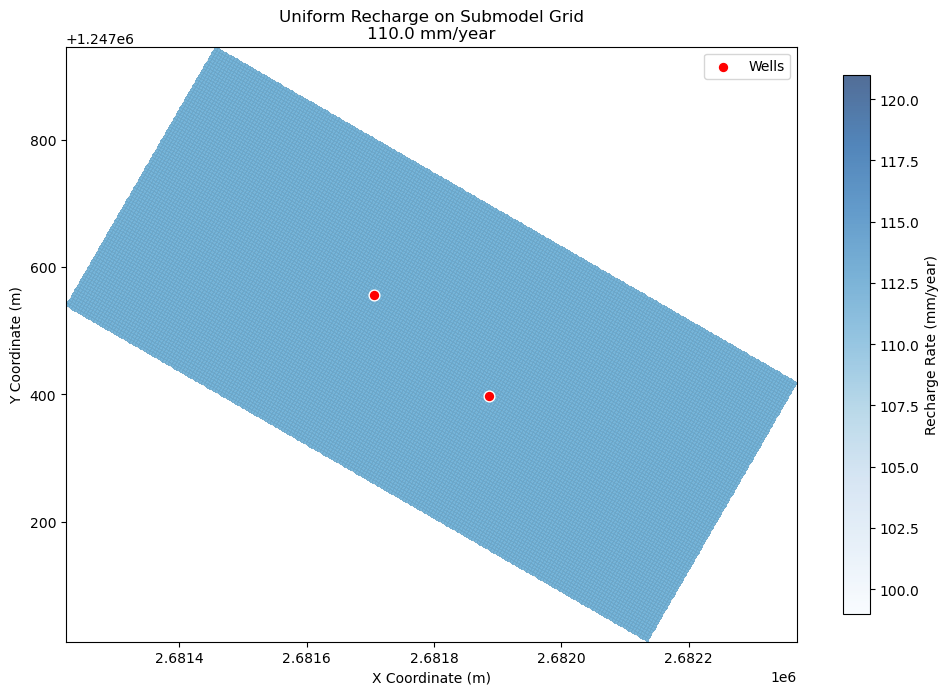

✓ RCH package created with uniform recharge from parent model


In [23]:
# Replace the RECH package code with this corrected version

# Extract recharge from parent model
parent_rch = m_parent_base.rch
if parent_rch is not None:
    parent_recharge = parent_rch.rech.array
    
    # Get representative recharge value from parent model
    # Check if recharge is 2D or 3D array
    if parent_recharge.ndim == 3:
        # 3D array: [stress_period, row, col]
        parent_rech_values = parent_recharge[0]  # First stress period
    else:
        # 2D array: [row, col]
        parent_rech_values = parent_recharge
    
    # Get active cells in parent model for statistics
    # Make sure we match the dimensions correctly
    if parent_ibound.ndim == 3:
        parent_active_mask = parent_ibound[0] == 1  # Use first layer
        print(f"Parent IBOUND shape: {parent_ibound.shape}, using layer 0")
    else:
        parent_active_mask = parent_ibound == 1
        print(f"Parent IBOUND shape: {parent_ibound.shape}")
    
    print(f"Parent recharge shape: {parent_rech_values.shape}")
    print(f"Parent active mask shape: {parent_active_mask.shape}")
    
    # Ensure dimensions match
    if parent_rech_values.shape != parent_active_mask.shape:
        print(f"Warning: Dimension mismatch between recharge {parent_rech_values.shape} and active mask {parent_active_mask.shape}")
        # If recharge is 1D (single value), expand it to match grid
        if parent_rech_values.ndim == 0 or (parent_rech_values.ndim == 1 and len(parent_rech_values) == 1):
            uniform_recharge = float(parent_rech_values) if parent_rech_values.ndim == 0 else parent_rech_values[0]
            print(f"Using scalar recharge value: {uniform_recharge:.6f} m/day")
        else:
            # Use fallback value
            uniform_recharge = 0.110 / 365.25  # 110 mm/year converted to m/day
            print(f"Dimension mismatch, using default recharge: {uniform_recharge:.6f} m/day")
    else:
        # Calculate representative recharge from active cells
        active_recharge_values = parent_rech_values[parent_active_mask]
        valid_recharge = active_recharge_values[active_recharge_values > 0]
        
        if len(valid_recharge) > 0:
            uniform_recharge = np.median(valid_recharge)
            print(f"Extracted recharge from parent model:")
            print(f"  Active cells with recharge: {len(valid_recharge):,}")
            print(f"  Recharge range: {valid_recharge.min():.6f} to {valid_recharge.max():.6f} m/day")
            print(f"  Median recharge: {uniform_recharge:.6f} m/day ({uniform_recharge*365.25*1000:.1f} mm/year)")
        else:
            # Fallback to typical values for Swiss conditions
            uniform_recharge = 0.110 / 365.25  # 110 mm/year converted to m/day
            print(f"No valid recharge found in parent model, using default: {uniform_recharge:.6f} m/day")
        
else:
    # No recharge package in parent model - use default
    uniform_recharge = 0.110 / 365.25  # m/day (110 mm/year)
    print(f"No RCH package in parent model, using default recharge: {uniform_recharge:.6f} m/day")

# Create uniform recharge array for submodel
sub_recharge_array = np.full((sub_modelgrid.nrow, sub_modelgrid.ncol), uniform_recharge)

# Create RCH package for submodel
sub_base_rch = flopy.modflow.ModflowRch(
    m_sub_base,
    rech=sub_recharge_array,
    nrchop=3  # Apply recharge to highest active cell
)

print(f"\nSubmodel RCH package created:")
print(f"  Uniform recharge rate: {uniform_recharge:.6f} m/day ({uniform_recharge*365.25*1000:.1f} mm/year)")
print(f"  Applied to grid: {sub_modelgrid.nrow} × {sub_modelgrid.ncol} cells")

# Visualize recharge distribution
fig, ax = plt.subplots(figsize=(10, 8))

pmv = flopy.plot.PlotMapView(modelgrid=submodel_grid, ax=ax)
im = pmv.plot_array(sub_recharge_array * 365.25 * 1000, cmap='Blues', alpha=0.7)  # Convert to mm/year for display
pmv.plot_grid(color='gray', alpha=0.3, linewidth=0.3)

# Plot wells for reference
wells_gdf.plot(ax=ax, color='red', markersize=60, label='Wells', zorder=5,
               edgecolors='white', linewidth=1)

cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('Recharge Rate (mm/year)')

ax.set_title(f'Uniform Recharge on Submodel Grid\n{uniform_recharge*365.25*1000:.1f} mm/year')
ax.set_xlabel('X Coordinate (m)')
ax.set_ylabel('Y Coordinate (m)')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

print("✓ RCH package created with uniform recharge from parent model")

#### 2.5.5 Solver & output control

In [24]:
# NWT Solver
nwt = flopy.modflow.ModflowNwt(
    m_sub_base,
    headtol=0.01,      # Head tolerance
    fluxtol=5.0,       # Flux tolerance  
    maxiterout=100,    # Maximum outer iterations
    thickfact=1e-05,   # Thickness factor for dry cells
    linmeth=1,         # Linear solution method (1=GMRES, 2=XMD)
    iprnwt=1,          # Print flag
    ibotav=0,          # Bottom averaging flag
    options='COMPLEX'  # Use complex option for difficult problems
)

# Output Control
oc = flopy.modflow.ModflowOc(
    m_sub_base,
    stress_period_data={(0, 0): ['save head', 'save budget']}
)

### 2.6 Run the sub_base model without wells
Now that we have set up the submodel with boundary conditions and aquifer properties, we will run the submodel without wells to establish baseline conditions. This will allow us to assess the natural groundwater flow patterns in the submodel area before implementing wells (our `sub_base` model).

In [25]:
# Write input files and run the submodel
print("Writing submodel input files...")
m_sub_base.write_input()

# Check model setup
print("\nChecking submodel setup...")
chk = m_sub_base.check(f=None, verbose=False)
if chk.summary_array is not None and len(chk.summary_array) > 0:
    print("Model check warnings found - reviewing...")
    for warning in chk.summary_array:
        print(f"  Warning: {warning}")
else:
    print("Model check passed")

# Run the submodel
print(f"\nRunning refined submodel...")
success, buff = m_sub_base.run_model(silent=False, report=True)

Writing submodel input files...

Checking submodel setup...
Model check passed

Running refined submodel...
FloPy is using the following executable to run the model: ../../../../.local/share/flopy/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: limmat_valley_model_nwt.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/09/28 23:12:46

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/09/28 23:12:46
 Elapsed run time:  0.166 Seconds

  Normal termination of simulation


### 2.7 Visualize sub_base model results

#### 2.7.1 Steady-State Groundwater Heads & Flow Vectors of sub_base model

Flow data loaded successfully for time 1.0
Head data loaded successfully for time 1.0


/Users/bea/Documents/GitHub/applied_groundwater_modelling/SUPPORT_REPO/src/plot_utils.py:472: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0)


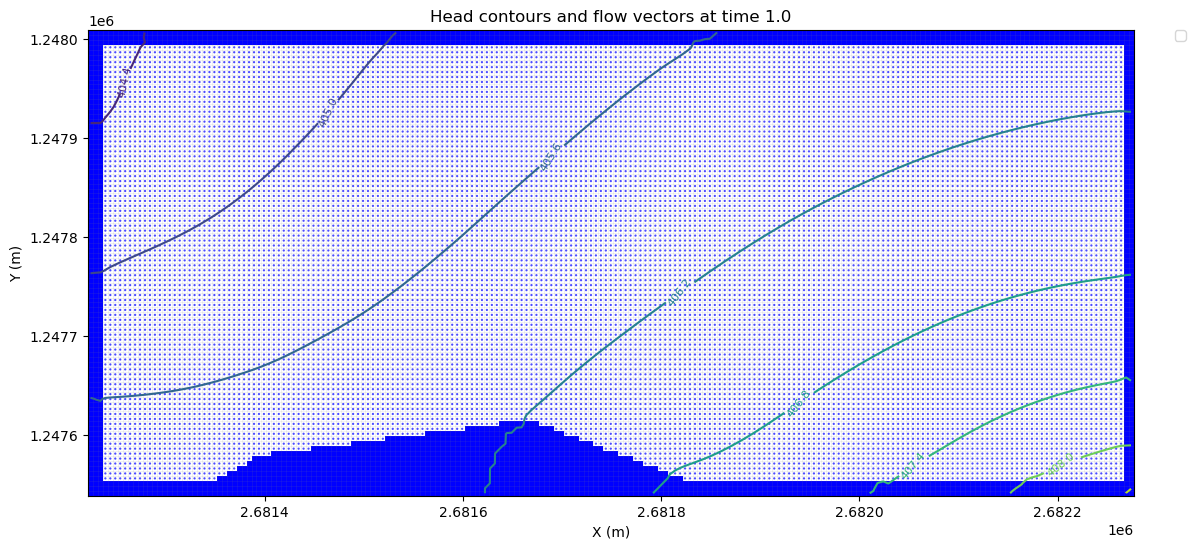

In [26]:
if success: 
    plot_utils.plot_model_results(m_sub_base, sub_base_ws, namefile.replace('.nam', ''),
                                  show_wells=False, show_ibound=True)
# Optional: save the image with plot_model_results by adding `save_path` parameter.

#### 2.7.2 Budget

In [27]:
budget_df = plot_utils.visualize_budget(
    workspace=sub_base_ws, model_name=namefile.replace('.nam', ''))

Budget terms (m³/day) at end of first stress period:

📈 INFLOWS:
------------------------------
                        0
STORAGE_IN           0.00
CONSTANT_HEAD_IN  2698.04
RECHARGE_IN        131.25
TOTAL_IN          2829.28

📉 OUTFLOWS:
------------------------------
                         0
STORAGE_OUT           0.00
CONSTANT_HEAD_OUT  2868.77
RECHARGE_OUT          0.00
TOTAL_OUT          2868.77

📊 SUMMARY:
------------------------------
                         0
IN-OUT              -39.48
PERCENT_DISCREPANCY  -1.39

💰 TOTALS:
------------------------------
Total Inflow:       5,659 m³/day
Total Outflow:      5,738 m³/day
Net Flow:          11,396 m³/day


## 3 Implement sub_wells model by adding the WEL Package
Now we copy the sub_base model to create the sub_wells model, where we will implement the well group. We will add the WEL package to the submodel and assign the appropriate pumping rates for our well group.

### 3.1 Set Up sub_wells model

In [28]:
# Save the m_sub_base model as m_sub_wells model and edit the workspace
m_sub_wells = flopy.modflow.Modflow.load(
    namefile.replace('.nam', ''), 
    model_ws=sub_base_ws,
    forgive=True, 
    check=False, 
    exe_name='mfnwt'
)
# Change workspace to the new directory sub_wells_ws
m_sub_wells.model_ws = sub_wells_ws

### 3.2 Add WEL Package to sub_wells model
#### 3.2.1 Map new wells to refined grid

Now we'll map the wells from the case study configuration to the refined grid cells and set up the WEL package with the appropriate pumping rates for the scenario.

In [ ]:
# Map wells to submodel grid cells
from flopy.utils.gridintersect import GridIntersect
from scipy.spatial import cKDTree

# Create GridIntersect object for the submodel
gi = GridIntersect(submodel_grid, method='vertex', rtree=True)

# Also prepare KDTree for fallback nearest-cell lookup
xc_sub = submodel_grid.xcellcenters
yc_sub = submodel_grid.ycellcenters
centers_flat = np.column_stack([xc_sub.ravel(), yc_sub.ravel()])
kdtree = cKDTree(centers_flat)

well_cells = []
for idx, well in wells_gdf.iterrows():
    well_x, well_y = well.geometry.x, well.geometry.y
    
    # Try GridIntersect first
    try:
        result = gi.intersect(Point(well_x, well_y))
        if len(result) > 0:
            # Extract row, col from intersection result
            if hasattr(result, 'iloc'):  # DataFrame
                row = int(result.iloc[0]['row'])  
                col = int(result.iloc[0]['col'])
            else:  # Other formats
                row = int(result[0]['row'])
                col = int(result[0]['col'])
        else:
            raise ValueError("No intersection found")
    except:
        # Fallback to nearest cell center
        dist, idx_flat = kdtree.query([well_x, well_y])
        row, col = np.unravel_index(idx_flat, xc_sub.shape)
    
    # Check if cell is active (not CHD)
    if submodel_ibound_clipped[0, row, col] == 1:  # Active cell
        well_cells.append({
            'well_idx': idx,
            'well_id': well.get('GWR_ID', f'well_{idx}'),
            'x': well_x,
            'y': well_y,
            'layer': 0,
            'row': row, 
            'col': col,
            'fassart': well.get('FASSART', 'Unknown')
        })
        print(f"Well {well.get('GWR_ID', idx)}: mapped to cell (L0, R{row}, C{col})")
    else:
        print(f"Warning: Well {well.get('GWR_ID', idx)} mapped to CHD cell (L0, R{row}, C{col}) - skipping")

print(f"\nMapped {len(well_cells)} wells to active submodel cells")

# Define pumping rates based on scenario
# Use the concessioned pumping rates from maps.ch.ch (if available)
pumping_rates = {
    'Entnahme': -well_rates_m3d,    # m³/day (negative = pumping)
    'Rückgabe': +well_rates_m3d,     # m³/day (positive = injection) 
}

# Create WEL stress period data
wel_data = []
for well_info in well_cells:
    # Determine pumping rate based on well type
    fassart = well_info['fassart']
    
    # Map FASSART to pumping rate
    if 'Entnahme' in fassart:
        rate = pumping_rates.get('Entnahme', -500)
    elif 'Rückgabe' in fassart:
        rate = pumping_rates.get('Rückgabe', 500)  
    else:
        rate = -100  # Default pumping rate
        print(f"Warning: Unknown FASSART '{fassart}' for well {well_info['well_id']}, using default rate")
    
    wel_data.append([well_info['layer'], well_info['row'], well_info['col'], rate])
    print(f"  {well_info['well_id']} ({fassart}): {rate} m³/day at (L{well_info['layer']}, R{well_info['row']}, C{well_info['col']})")

print(f"\nWEL package data created with {len(wel_data)} wells")
total_pumping = sum(rate for _, _, _, rate in wel_data if rate < 0)
total_injection = sum(rate for _, _, _, rate in wel_data if rate > 0)
print(f"  Total pumping: {total_pumping:,.0f} m³/day")
print(f"  Total injection: {total_injection:,.0f} m³/day")
print(f"  Net extraction: {total_pumping + total_injection:,.0f} m³/day")

Well b010210_01: mapped to cell (L0, R52, C129)
Well b010210_02: mapped to cell (L0, R42, C81)

Mapped 2 wells to active submodel cells
  b010210_01 (Vertikalbrunnen mit Rückversickerung: Entnahme): -120959.99999999999 m³/day at (L0, R52, C129)
  b010210_02 (Vertikalbrunnen mit Rückversickerung: Rückgabe): 120959.99999999999 m³/day at (L0, R42, C81)

WEL package data created with 2 wells
  Total pumping: -120,960 m³/day
  Total injection: 120,960 m³/day
  Net extraction: 0 m³/day


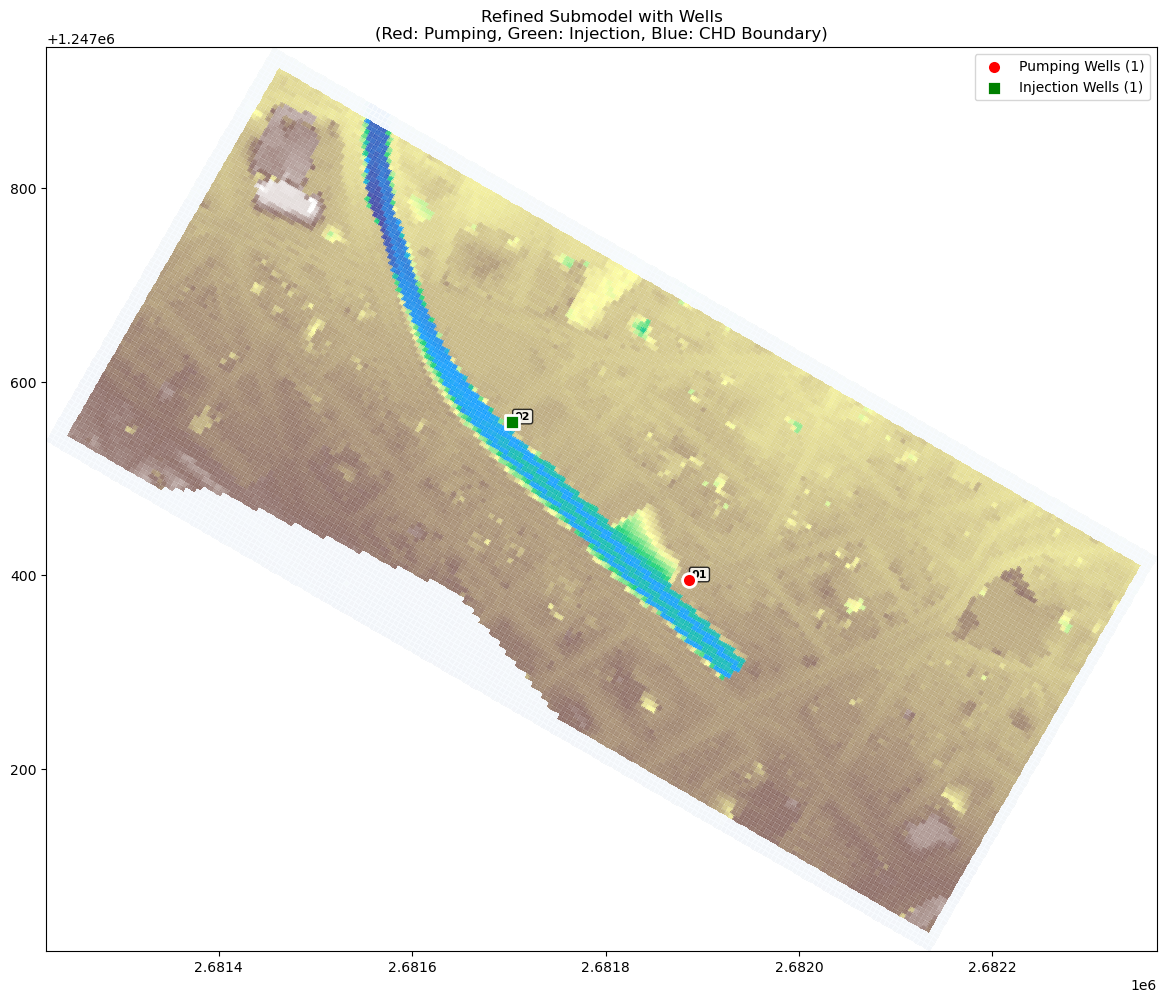

In [30]:
# Visualize wells on the refined submodel grid
fig, ax = plt.subplots(figsize=(12, 10))

# Plot submodel grid
pmv = flopy.plot.PlotMapView(modelgrid=submodel_grid, ax=ax)
pmv.plot_array(submodel_grid.top, alpha=0.6, cmap='terrain')
pmv.plot_grid(color='white', alpha=0.5, linewidth=0.3)

# Plot boundary conditions
im_bound = pmv.plot_array(np.ma.masked_where(submodel_ibound_clipped[0] != -1, submodel_ibound_clipped[0]), 
                         cmap='Blues', alpha=0.8)

# Plot wells with different colors for different types
pumping_wells = [(info['row'], info['col']) for info in well_cells 
                 if any(rate < 0 for _, r, c, rate in wel_data if r == info['row'] and c == info['col'])]
injection_wells = [(info['row'], info['col']) for info in well_cells 
                   if any(rate > 0 for _, r, c, rate in wel_data if r == info['row'] and c == info['col'])]

if pumping_wells:
    p_rows, p_cols = zip(*pumping_wells)
    ax.scatter(submodel_grid.xcellcenters[p_rows, p_cols],
              submodel_grid.ycellcenters[p_rows, p_cols],
              c='red', s=100, marker='o', edgecolors='white', linewidth=2,
              label=f'Pumping Wells ({len(pumping_wells)})', zorder=5)

if injection_wells:
    i_rows, i_cols = zip(*injection_wells) 
    ax.scatter(submodel_grid.xcellcenters[i_rows, i_cols],
              submodel_grid.ycellcenters[i_rows, i_cols], 
              c='green', s=100, marker='s', edgecolors='white', linewidth=2,
              label=f'Injection Wells ({len(injection_wells)})', zorder=5)

# Add well labels
for well_info in well_cells:
    ax.annotate(f"{well_info['well_id'].split('_')[-1]}", 
                xy=(submodel_grid.xcellcenters[well_info['row'], well_info['col']],
                    submodel_grid.ycellcenters[well_info['row'], well_info['col']]),
                xytext=(2, 2), textcoords='offset points',
                fontsize=8, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

ax.set_title('Refined Submodel with Wells\n(Red: Pumping, Green: Injection, Blue: CHD Boundary)')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()



#### 3.2.3 Write WEL package

/var/folders/fx/fhbs7qgd6998fvtd5n8bs1lr0000gn/T/ipykernel_31679/3855582608.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


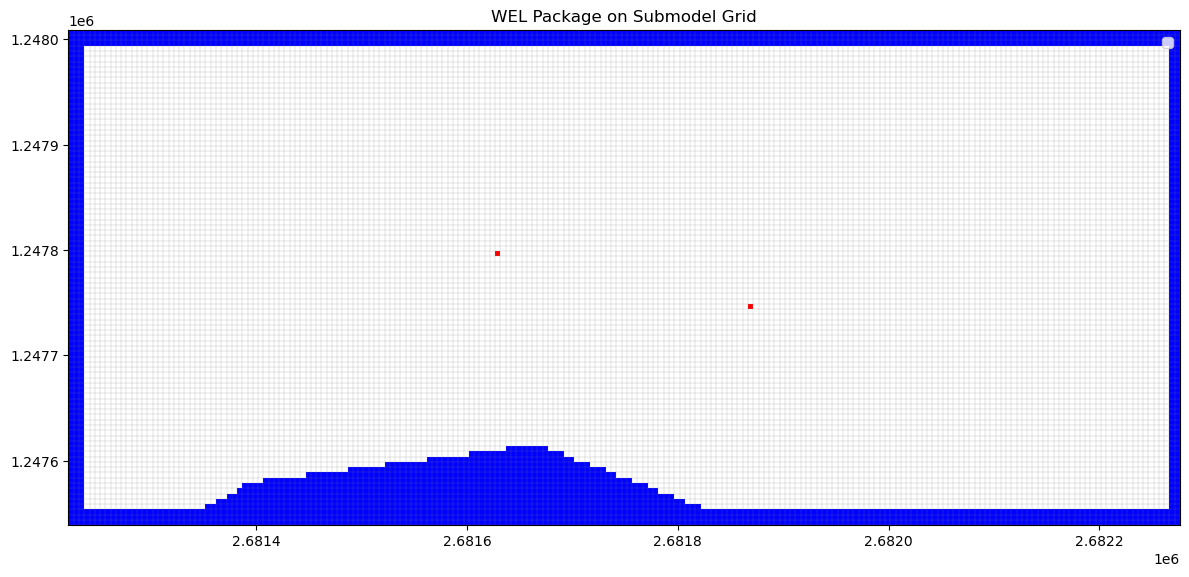

In [31]:
# Define the wel package for the submodel
wel = flopy.modflow.ModflowWel(m_sub_wells, stress_period_data={0: wel_data})

# Visualize the wel package data on the submodel grid
fig, ax = plt.subplots(figsize=(12, 10))
# Plot submodel grid
pmv = flopy.plot.PlotMapView(m_sub_wells, ax=ax)
#pmv.plot_array(submodel_grid.top, alpha=0.6, cmap='terrain')
pmv.plot_ibound()
pmv.plot_grid(color='grey', alpha=0.5, linewidth=0.3)
# Plot wells with different colors for different types
pmv.plot_bc(package=wel)
ax.set_title('WEL Package on Submodel Grid')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

### 3.3. Set Up and Run Submodel sub_wells

Finally, we'll complete the submodel setup with all necessary packages and run the simulation. We'll use MODFLOW-NWT for better convergence with the refined grid.

In [32]:
# Write input files and run the submodel
print("Writing submodel input files...")
m_sub_wells.write_input()

# Check model setup
print("\nChecking submodel setup...")
chk = m_sub_wells.check(f=None, verbose=False)
if chk.summary_array is not None and len(chk.summary_array) > 0:
    print("Model check warnings found - reviewing...")
    for warning in chk.summary_array:
        print(f"  Warning: {warning}")
else:
    print("Model check passed")

# Run the submodel
print(f"\nRunning refined submodel...")
success, buff = m_sub_wells.run_model(silent=False, report=True)

Writing submodel input files...

Checking submodel setup...
Errors and/or Warnings encountered.
Model check warnings found - reviewing...

Running refined submodel...
FloPy is using the following executable to run the model: ../../../../.local/share/flopy/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: limmat_valley_model_nwt.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/09/28 23:12:48

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/09/28 23:12:53
 Elapsed run time:  4.453 Seconds

  Normal term

### 3.4 Visualize sub_wells model results

#### 3.4.1 Steady-State Groundwater Heads & Flow Vectors of sub_wells model

Head data loaded successfully for time 1.0


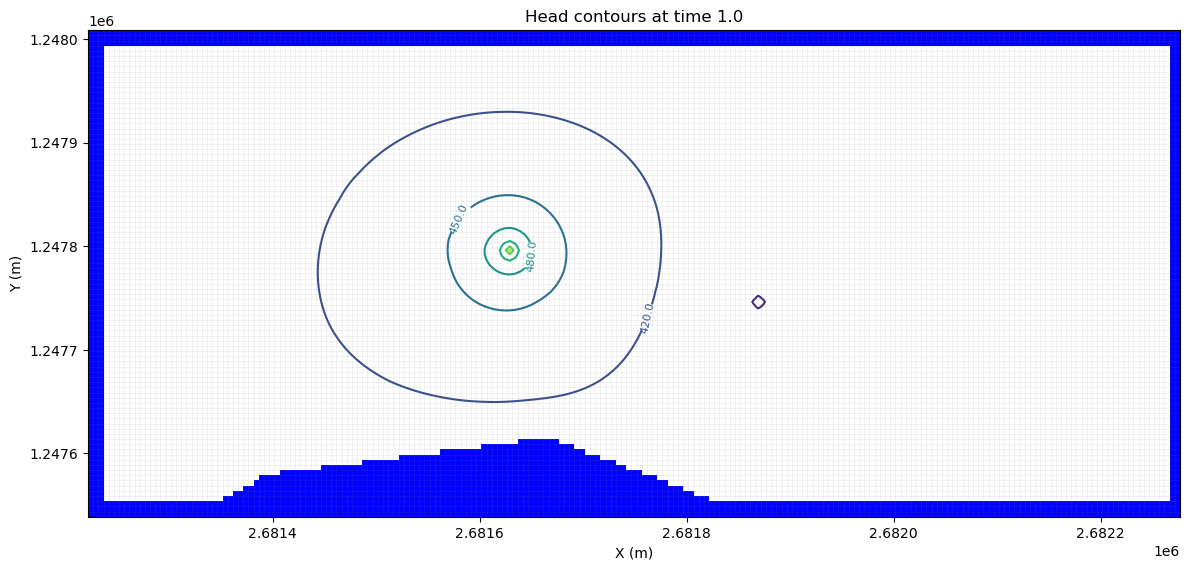

In [33]:
if success: 
    plot_utils.plot_model_results(m_sub_wells, sub_wells_ws, namefile.replace('.nam', ''),
                                  show_wells=False, show_ibound=True, show_vectors=False)

#### 3.4.2 Budget

In [34]:
budget_df = plot_utils.visualize_budget(
    workspace=sub_base_ws, model_name=namefile.replace('.nam', ''))

Budget terms (m³/day) at end of first stress period:

📈 INFLOWS:
------------------------------
                        0
STORAGE_IN           0.00
CONSTANT_HEAD_IN  2698.04
RECHARGE_IN        131.25
TOTAL_IN          2829.28

📉 OUTFLOWS:
------------------------------
                         0
STORAGE_OUT           0.00
CONSTANT_HEAD_OUT  2868.77
RECHARGE_OUT          0.00
TOTAL_OUT          2868.77

📊 SUMMARY:
------------------------------
                         0
IN-OUT              -39.48
PERCENT_DISCREPANCY  -1.39

💰 TOTALS:
------------------------------
Total Inflow:       5,659 m³/day
Total Outflow:      5,738 m³/day
Net Flow:          11,396 m³/day


## 3.5 Particle tracking with MODPATH (Optional)
Excellent! Now that you've successfully placed the geothermal wells into the model and performed your simulation, we're moving on to a critical design validation step. The goal is to ensure the system is sustainable and won't sabotage its own efficiency over its operational life. We need to confirm that the thermally-altered water from the injection well won't be drawn back into the extraction well too quickly, a problem known as thermal breakthrough ♨️. To do this, we'll use MODPATH as a kind of hydrogeological GPS. You will perform a forward particle tracking simulation, releasing a set of imaginary water particles from the injection well's screen. MODPATH will then calculate the path and, most importantly, the travel time for these particles as they move through the aquifer. Your objective is to find the travel time for the fastest particle to reach the extraction well; if this time is greater than 30 years, the system's design is considered robust and sustainable.

In [74]:
# --- Step 1: Get required info from your existing NWT model ---

# Assume 'm_sub_wells' is your successfully run Flopy model object
# Make sure the workspace is correctly defined
model_ws = m_sub_wells.model_ws 

# Get well data for the first stress period
well_data = m_sub_wells.wel.stress_period_data[0]

# Filter for INJECTION wells only (where flux is positive)
injection_wells = well_data[well_data['flux'] > 0]

# Extract the layer, row, column for the injection wells
# This will be used as the starting locations for our particles
injection_locs = injection_wells[['k', 'i', 'j']]

print(f"Found {len(injection_locs)} injection wells for particle tracking.")
print(f"Injection well locations (layer, row, col):")
if len(injection_locs) > 1:
    for idx, loc in injection_locs.iterrows():
        print(f"  Well {injection_wells.iloc[idx]['well_id']}: (L{loc['k']}, R{loc['i']}, C{loc['j']})")    
elif len(injection_locs) == 1:
    print(f"  Well {injection_locs}: (L{injection_locs['k']}, R{injection_locs['i']}, C{injection_locs['j']})")
elif len(injection_locs) == 0:
    print("No injection wells found. Skipping particle tracking from injection wells.")

Found 1 injection wells for particle tracking.
Injection well locations (layer, row, col):
  Well [(0, 42, 81)]: (L[0], R[42], C[81])


In [85]:
# --- Step 2: Create the MODPATH 7 simulation with 100 particles per well ---

# First, check if we have injection wells
print(f"Checking injection wells...")
print(f"Total wells in WEL package: {len(well_data)}")
print(f"Injection wells found: {len(injection_wells)}")

if len(injection_wells) == 0:
    print("No injection wells found - using all wells for particle tracking")
    # Use all wells if no injection wells are found
    all_wells_locs = [[int(row['k']), int(row['i']), int(row['j'])] for row in well_data]
    particle_start_locs = all_wells_locs
    group_name = "AllWells"
else:
    # Fix: Handle numpy recarray properly for single injection well
    if len(injection_wells) == 1:
        # Single injection well - extract k, i, j directly using item() to avoid deprecation warning
        k = injection_wells['k'].item() if hasattr(injection_wells['k'], 'item') else int(injection_wells['k'])
        i = injection_wells['i'].item() if hasattr(injection_wells['i'], 'item') else int(injection_wells['i'])
        j = injection_wells['j'].item() if hasattr(injection_wells['j'], 'item') else int(injection_wells['j'])
        particle_start_locs = [[k, i, j]]
        print(f"Single injection well at: (L{k}, R{i}, C{j})")
    else:
        # Multiple injection wells - iterate through the recarray
        particle_start_locs = []
        for well in injection_wells:
            k, i, j = int(well['k']), int(well['i']), int(well['j'])
            particle_start_locs.append([k, i, j])
            print(f"Injection well at: (L{k}, R{i}, C{j})")
    
    group_name = "InjectionWells"

print(f"Particle starting locations: {len(particle_start_locs)}")

# Define executable names
mpexe = "mp7"
mp_name = f"{m_sub_wells.name}_mp7_forward"

# Number of particles per well
particles_per_well = 100

try:
    # Create the Modpath7 object, linking it to your NWT model
    mp = flopy.modpath.Modpath7(
        modelname=mp_name,
        exe_name=mpexe,
        model_ws=model_ws,
        flowmodel=m_sub_wells, # This is the crucial link to your NWT model!
    )

    # Create the MODPATH 7 basic package
    porosity = 0.2
    mpbas = flopy.modpath.Modpath7Bas(
        model=mp,
        porosity=porosity
    )

    # Use ParticleGroupLRCTemplate - this is the easiest approach for 100 particles per well
    template_particles = []
    for well_idx, well_loc in enumerate(particle_start_locs):
        k, i, j = well_loc
        
        # Create LRCParticleData with correct parameters (no 'drape')
        particle_data = flopy.modpath.LRCParticleData(
            structured=True,
            # Place particles in a regular grid within the cell
            localx=np.linspace(0.1, 0.9, 10),  # 10 positions in X direction
            localy=np.linspace(0.1, 0.9, 10),  # 10 positions in Y direction  
            localz=[0.5],  # Single Z position (middle of layer)
            timeoffset=0.0,
            # Specify the single cell location
            lrcregions=[[[k, i, j, k, i, j]]]  # [layer_min, row_min, col_min, layer_max, row_max, col_max]
        )
        
        # Use ParticleGroupLRCTemplate for regular particle distribution
        particle_group_template = flopy.modpath.ParticleGroupLRCTemplate(
            particlegroupname=f"{group_name}_Template_Well_{well_idx+1}",
            particledata=particle_data,
            filename=f"{mp_name}_template_well_{well_idx+1}.sloc"
        )
        
        template_particles.append(particle_group_template)
        print(f"Created particle template for well {well_idx+1} at (L{k}, R{i}, C{j}) with {particles_per_well} particles")

    print(f"Created particle templates for {len(template_particles)} wells with {particles_per_well} particles each")

    # Create the MODPATH 7 simulation package with template particles
    mpsim = flopy.modpath.Modpath7Sim(
        model=mp,
        simulationtype="pathline",       # Simulate pathlines
        trackingdirection="forward",     # Track particles forward in time
        weaksinkoption="pass_through",   # How to handle weak sinks
        weaksourceoption="pass_through", # How to handle weak sources
        referencetime=0,                 # Start tracking at time 0
        stoptimeoption="extend",         # Extend tracking beyond MODFLOW time
        particlegroups=template_particles  # Use template-based particles
    )

    print("✓ MODPATH 7 simulation setup completed successfully")
    print(f"✓ Total particles created: {len(particle_start_locs) * particles_per_well}")
    
    # Write MODPATH input files
    print("Writing MODPATH input files...")
    mp.write_input()
    
    # Run MODPATH simulation
    print("Running MODPATH simulation...")
    success, buff = mp.run_model(silent=False, report=True)
    
    if success:
        print("✓ MODPATH simulation completed successfully")
        
        # Load and analyze results
        try:
            # Load pathline results
            pathline_file = os.path.join(model_ws, f"{mp_name}.mppth")
            if os.path.exists(pathline_file):
                pth = flopy.utils.PathlineFile(pathline_file)
                pathlines = pth.get_alldata()
                
                print(f"Pathline results loaded:")
                print(f"  Number of particles tracked: {len(pathlines)}")
                
                # Load endpoint results
                endpoint_file = os.path.join(model_ws, f"{mp_name}.mpend")
                if os.path.exists(endpoint_file):
                    ept = flopy.utils.EndpointFile(endpoint_file)
                    endpoints = ept.get_alldata()
                    
                    print(f"  Number of endpoints: {len(endpoints)}")
                    
                    # Analyze travel times with statistics for multiple particles
                    if len(endpoints) > 0:
                        travel_times = endpoints['time']
                        print(f"  Travel time statistics:")
                        print(f"    Minimum: {travel_times.min():.1f} days")
                        print(f"    Maximum: {travel_times.max():.1f} days")
                        print(f"    Mean: {travel_times.mean():.1f} days")
                        print(f"    Median: {np.median(travel_times):.1f} days")
                        print(f"    Standard deviation: {travel_times.std():.1f} days")
                        
                        # Check for thermal breakthrough (30 years = ~11,000 days)
                        min_travel_time_years = travel_times.min() / 365.25
                        percentile_10_years = np.percentile(travel_times, 10) / 365.25
                        
                        print(f"\n  Thermal breakthrough assessment:")
                        print(f"    Fastest particle: {min_travel_time_years:.1f} years")
                        print(f"    10th percentile: {percentile_10_years:.1f} years")
                        
                        if min_travel_time_years > 30:
                            print(f"    ✓ System design is sustainable! Minimum travel time: {min_travel_time_years:.1f} years > 30 years")
                        else:
                            print(f"    ⚠ Potential thermal breakthrough risk! Minimum travel time: {min_travel_time_years:.1f} years < 30 years")
                
                # Create visualization of pathlines
                print("\nCreating pathline visualization...")
                fig = plt.figure(figsize=(12, 10))
                ax = fig.add_subplot(1, 1, 1, aspect="equal")
                pmv = flopy.plot.PlotMapView(model=m_sub_wells, ax=ax)
                
                # Plot model grid and boundaries
                pmv.plot_grid(alpha=0.3)
                pmv.plot_ibound(alpha=0.5)
                
                # Plot pathlines
                pmv.plot_pathline(pth, layer='all', colors="blue", lw=1.0, alpha=0.7)
                
                # Plot endpoints with travel time colors
                pmv.plot_endpoint(ept, direction='ending', colorbar=True, shrink=0.5)
                
                # Plot wells - get well coordinates from submodel grid
                wel_data = m_sub_wells.wel.stress_period_data[0]
                wel_pumping = []
                wel_injection = []
                
                for wel_cell in wel_data:
                    layer, row, col, rate = wel_cell
                    x = m_sub_wells.modelgrid.xcellcenters[row, col]
                    y = m_sub_wells.modelgrid.ycellcenters[row, col]
                    
                    if rate < 0:  # Pumping
                        wel_pumping.append((x, y, rate))
                    else:  # Injection
                        wel_injection.append((x, y, rate))
                
                if wel_pumping:
                    pump_x, pump_y, pump_rates = zip(*wel_pumping)
                    ax.scatter(pump_x, pump_y, c='red', s=150, marker='o',
                             edgecolors='white', linewidth=2, label='Pumping Wells', zorder=5)
                
                if wel_injection:
                    inj_x, inj_y, inj_rates = zip(*wel_injection)
                    ax.scatter(inj_x, inj_y, c='green', s=150, marker='s',
                             edgecolors='white', linewidth=2, label='Injection Wells', zorder=5)
                
                ax.set_title(f"Forward Pathlines from Injection Wells\n{len(pathlines)} particles tracked")
                ax.legend()
                plt.tight_layout()
                plt.show()
                
            else:
                print(f"Pathline file not found: {pathline_file}")
                
        except Exception as e:
            print(f"Error loading MODPATH results: {e}")
            
    else:
        print("✗ MODPATH simulation failed")
        for line in buff:
            print(line)
            
except Exception as e:
    print(f"Error setting up MODPATH: {e}")
    print("MODPATH particle tracking is optional - continuing with analysis...")

Checking injection wells...
Total wells in WEL package: 2
Injection wells found: 1
Single injection well at: (L0, R42, C81)
Particle starting locations: 1
Error setting up MODPATH: LRCParticleData.__init__() got an unexpected keyword argument 'structured'
MODPATH particle tracking is optional - continuing with analysis...


## 4 Implement forcing scenario in parent model parent_scenario

### 4.1 Set up parent_scenario model

In [35]:
# Save the m_sub_base model as m_parent_scenario model and edit the workspace
m_parent_scenario = flopy.modflow.Modflow.load(
    namefile.replace('.nam', ''), 
    model_ws=parent_base_ws,
    forgive=True, 
    check=False, 
    exe_name='mfnwt'
)
# Change workspace to the new directory parent_scenario_ws
m_parent_scenario.model_ws = parent_scenario_ws

### 4.1 Implement scenario changes in parent_scenario model

### 4.2 Run parent_scenario model

### 4.3 Visualize parent_scenario model results

## 5 Update the CHD boundary for submodel_scenario

### 5.1 Set up sub_scenario model

## 6 Comparison of Results

### 6.1 Compare sub_base vs sub_wells

#### 6.1.1 Steady-State Groundwater Heads

/var/folders/fx/fhbs7qgd6998fvtd5n8bs1lr0000gn/T/ipykernel_31679/361496660.py:218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Head difference plot saved to: /Users/bea/applied_groundwater_modelling_data/limmat/case_study_group_0/results/head_difference_analysis.png


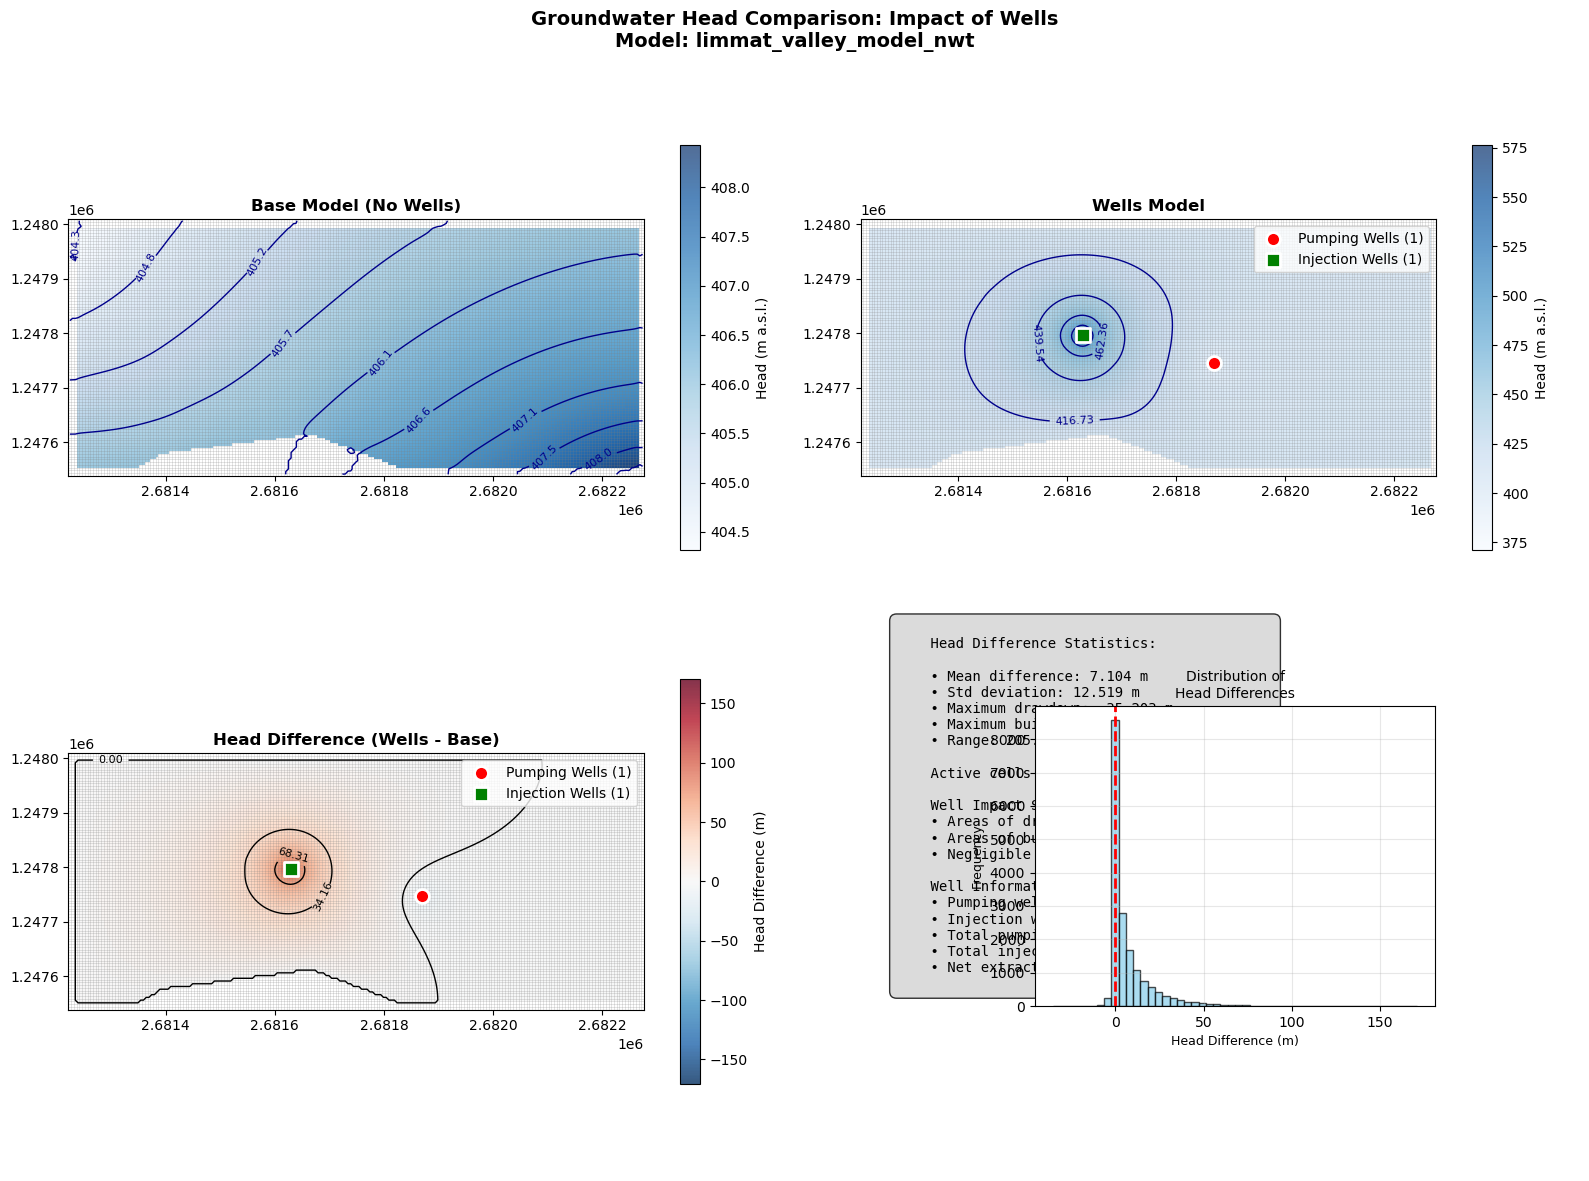

In [36]:
def plot_head_difference(model_base, model_wells, ws_base, ws_wells, model_name, 
                        save_path=None):
    """
    Plot the difference in groundwater heads between base model and wells model.
    
    Parameters:
    -----------
    model_base : flopy.modflow.Modflow
        Base model without wells
    model_wells : flopy.modflow.Modflow  
        Model with wells implemented
    ws_base : str
        Workspace path for base model
    ws_wells : str
        Workspace path for wells model
    model_name : str
        Model name for file naming
    save_path : str, optional
        Path to save the figure
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    head_diff : numpy.ndarray
        Array of head differences (wells - base)
    """
    
    # Load head files
    hds_base_path = os.path.join(ws_base, f"{model_name}.hds")
    hds_wells_path = os.path.join(ws_wells, f"{model_name}.hds")
    
    if not os.path.exists(hds_base_path):
        raise FileNotFoundError(f"Base model heads file not found: {hds_base_path}")
    if not os.path.exists(hds_wells_path):
        raise FileNotFoundError(f"Wells model heads file not found: {hds_wells_path}")
    
    # Load heads
    headobj_base = flopy.utils.HeadFile(hds_base_path)
    headobj_wells = flopy.utils.HeadFile(hds_wells_path)
    
    heads_base = headobj_base.get_data()[0]  # Layer 0, stress period 0
    heads_wells = headobj_wells.get_data()[0]  # Layer 0, stress period 0
    
    # Calculate head difference (wells model - base model)
    head_diff = heads_wells - heads_base
    
    # Mask inactive cells
    ibound = model_base.bas6.ibound.array[0]
    head_diff_masked = np.ma.masked_where(ibound <= 0, head_diff)
    heads_base_masked = np.ma.masked_where(ibound <= 0, heads_base)
    
    # Extract well locations from WEL package
    wel_wells = []
    wel_pumping = []
    wel_injection = []
    
    if hasattr(model_wells, 'wel') and model_wells.wel is not None:
        wel_data = model_wells.wel.stress_period_data[0]  # First stress period
        for wel_cell in wel_data:
            layer, row, col, rate = wel_cell
            x = model_wells.modelgrid.xcellcenters[row, col]
            y = model_wells.modelgrid.ycellcenters[row, col]
            
            if rate < 0:  # Pumping (negative rate)
                wel_pumping.append((x, y, rate))
            else:  # Injection (positive rate)
                wel_injection.append((x, y, rate))
            
            wel_wells.append((x, y, rate, row, col))
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Base model heads
    ax1 = axes[0, 0]
    pmv1 = flopy.plot.PlotMapView(model=model_base, ax=ax1)
    im1 = pmv1.plot_array(heads_base_masked, alpha=0.7, cmap='Blues')
    pmv1.plot_grid(color='gray', alpha=0.3, linewidth=0.5)
    
    # Add contours for base heads
    contour_levels_base = np.linspace(np.nanmin(heads_base_masked), 
                                     np.nanmax(heads_base_masked), 10)
    cont1 = pmv1.contour_array(heads_base_masked, levels=contour_levels_base, 
                              colors='darkblue', linewidths=1, linestyles='-')
    ax1.clabel(cont1, inline=True, fontsize=8, fmt='%.1f')
    
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.7)
    cbar1.set_label('Head (m a.s.l.)', fontsize=10)
    ax1.set_title('Base Model (No Wells)', fontweight='bold')
    ax1.set_aspect('equal')
    
    # Plot 2: Wells model heads
    ax2 = axes[0, 1]
    pmv2 = flopy.plot.PlotMapView(model=model_wells, ax=ax2)
    im2 = pmv2.plot_array(np.ma.masked_where(ibound <= 0, heads_wells), 
                         alpha=0.7, cmap='Blues')
    pmv2.plot_grid(color='gray', alpha=0.3, linewidth=0.5)
    
    # Add contours for wells heads
    heads_wells_masked = np.ma.masked_where(ibound <= 0, heads_wells)
    contour_levels_wells = np.linspace(np.nanmin(heads_wells_masked), 
                                      np.nanmax(heads_wells_masked), 10)
    cont2 = pmv2.contour_array(heads_wells_masked, levels=contour_levels_wells, 
                              colors='darkblue', linewidths=1, linestyles='-')
    ax2.clabel(cont2, inline=True, fontsize=8, fmt='%.2f')
    
    # Plot wells from WEL package
    if wel_pumping:
        pump_x, pump_y, pump_rates = zip(*wel_pumping)
        ax2.scatter(pump_x, pump_y, c='red', s=100, marker='o', 
                   edgecolors='white', linewidth=2, label=f'Pumping Wells ({len(wel_pumping)})', 
                   zorder=5)
    
    if wel_injection:
        inj_x, inj_y, inj_rates = zip(*wel_injection)
        ax2.scatter(inj_x, inj_y, c='green', s=100, marker='s',
                   edgecolors='white', linewidth=2, label=f'Injection Wells ({len(wel_injection)})', 
                   zorder=5)
    
    if wel_wells:
        ax2.legend(loc='upper right')
    
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.7)
    cbar2.set_label('Head (m a.s.l.)', fontsize=10)
    ax2.set_title('Wells Model', fontweight='bold')
    ax2.set_aspect('equal')
    
    # Plot 3: Head difference (main plot)
    ax3 = axes[1, 0]
    pmv3 = flopy.plot.PlotMapView(model=model_base, ax=ax3)
    
    # Use diverging colormap for differences
    max_diff = np.nanmax(np.abs(head_diff_masked))
    im3 = pmv3.plot_array(head_diff_masked, alpha=0.8, cmap='RdBu_r', 
                         vmin=-max_diff, vmax=max_diff)
    pmv3.plot_grid(color='gray', alpha=0.3, linewidth=0.5)
    
    # Add contours for head differences
    diff_levels = np.linspace(-max_diff, max_diff, 11)
    cont3 = pmv3.contour_array(head_diff_masked, levels=diff_levels, 
                              colors='black', linewidths=1, linestyles='-')
    ax3.clabel(cont3, inline=True, fontsize=8, fmt='%.2f')
    
    # Plot wells from WEL package on difference plot
    if wel_pumping:
        pump_x, pump_y, pump_rates = zip(*wel_pumping)
        ax3.scatter(pump_x, pump_y, c='red', s=100, marker='o',
                   edgecolors='white', linewidth=2, label=f'Pumping Wells ({len(wel_pumping)})', 
                   zorder=5)
    
    if wel_injection:
        inj_x, inj_y, inj_rates = zip(*wel_injection)
        ax3.scatter(inj_x, inj_y, c='green', s=100, marker='s',
                   edgecolors='white', linewidth=2, label=f'Injection Wells ({len(wel_injection)})', 
                   zorder=5)
    
    if wel_wells:
        ax3.legend(loc='upper right')
    
    cbar3 = plt.colorbar(im3, ax=ax3, shrink=0.7)
    cbar3.set_label('Head Difference (m)', fontsize=10)
    ax3.set_title('Head Difference (Wells - Base)', fontweight='bold')
    ax3.set_aspect('equal')
    
    # Plot 4: Statistics and summary
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Calculate statistics
    valid_diff = head_diff_masked.compressed()  # Remove masked values
    
    # Calculate well statistics
    total_pumping = sum(rate for _, _, rate in wel_pumping) if wel_pumping else 0
    total_injection = sum(rate for _, _, rate in wel_injection) if wel_injection else 0
    net_extraction = total_pumping + total_injection
    
    stats_text = f"""
    Head Difference Statistics:
    
    • Mean difference: {np.mean(valid_diff):.3f} m
    • Std deviation: {np.std(valid_diff):.3f} m
    • Maximum drawdown: {np.min(valid_diff):.3f} m
    • Maximum buildup: {np.max(valid_diff):.3f} m
    • Range: {np.max(valid_diff) - np.min(valid_diff):.3f} m
    
    Active cells analyzed: {len(valid_diff):,}
    
    Well Impact Summary:
    • Areas of drawdown (red): {np.sum(valid_diff < -0.01):,} cells
    • Areas of buildup (blue): {np.sum(valid_diff > 0.01):,} cells  
    • Negligible change: {np.sum(np.abs(valid_diff) <= 0.01):,} cells
    
    Well Information:
    • Pumping wells: {len(wel_pumping)}
    • Injection wells: {len(wel_injection)}
    • Total pumping: {total_pumping:,.0f} m³/day
    • Total injection: {total_injection:,.0f} m³/day
    • Net extraction: {net_extraction:,.0f} m³/day
    """
    
    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
    
    # Add histogram of differences
    ax4_hist = fig.add_axes([0.65, 0.15, 0.25, 0.25])  # [left, bottom, width, height]
    ax4_hist.hist(valid_diff, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax4_hist.axvline(0, color='red', linestyle='--', linewidth=2)
    ax4_hist.set_xlabel('Head Difference (m)', fontsize=9)
    ax4_hist.set_ylabel('Frequency', fontsize=9)
    ax4_hist.set_title('Distribution of\nHead Differences', fontsize=10)
    ax4_hist.grid(True, alpha=0.3)
    
    # Overall title
    fig.suptitle('Groundwater Head Comparison: Impact of Wells\n' + 
                 f'Model: {model_name}', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Head difference plot saved to: {save_path}")
    
    plt.show()
    
    return fig, axes, head_diff_masked

# Updated usage example (removed wells_gdf parameter):
fig, axes, head_diff = plot_head_difference(
    model_base=m_sub_base,
    model_wells=m_sub_wells, 
    ws_base=sub_base_ws,
    ws_wells=sub_wells_ws,
    model_name=namefile.replace('.nam', ''),
    save_path=os.path.join(results_ws, 'head_difference_analysis.png')
)